## 0: Setup

In [ ]:
import os, json, random, warnings
from pathlib import Path
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import StratifiedGroupKFold
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, TerminateOnNaN
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.layers import Conv2D, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from sklearn.metrics import confusion_matrix
import seaborn as sns
import json
import shutil

warnings.filterwarnings("ignore")
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

ROOT = Path.cwd().parent        # notebook/ -> project root
BASE_DIR = ROOT / "MINI-DDSM-Complete-PNG-16"
DATA_XLSX = ROOT / "Data.xlsx"

OUT_DIR     = ROOT / "outputs"
METRICS_DIR = OUT_DIR / "metrics"
PLOTS_DIR   = OUT_DIR / "plots"
VQC_DIR     = OUT_DIR / "visual_qc"
MODELS_DIR = ROOT / "models"

for d in [OUT_DIR, METRICS_DIR, PLOTS_DIR, VQC_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

IMG_SIZE   = (224, 224)
BATCH_SIZE = 16
CLASS_NAMES = ["Non-malignant", "Malignant"]

## 1: Helper Functions

In [ ]:
def infer_view(fn):
    s = str(fn).upper()
    if "MLO" in s: return "MLO"
    if "CC"  in s: return "CC"
    return "Unknown"

def infer_patient_id(fn):
    s = Path(fn).stem
    return s.split("_")[0] if "_" in s else s

def map_status_to_label_name(x):
    x = str(x).strip().lower()
    if x in ["cancer", "malignant", "malig"]: return "Malignant"
    if x in ["normal", "benign", "non-malignant", "nonmalignant"]: return "Non-malignant"
    return None

def resolve_path(pstr):
    if pd.isna(pstr): return None
    s = str(pstr).replace("\\", "/").strip()
    p = Path(s)
    if p.is_absolute():
        return str(p) if p.exists() else None
    q = (BASE_DIR / s).resolve()
    return str(q) if q.exists() else None


def trim_borders(img, frac=0.05, pad_ratio=0.015, close_kernel=7):
    # tiny uniform shave by fraction
    h, w = img.shape[:2]
    dy = max(1, int(h * frac))
    dx = max(1, int(w * frac))
    y0, y1 = dy, max(dy + 1, h - dy)
    x0, x1 = dx, max(dx + 1, w - dx)
    img = img[y0:y1, x0:x1]

    # Otsu -> largest component -> bbox + pad
    g = cv2.GaussianBlur(img, (5,5), 0)
    _, th = cv2.threshold(g, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if (th > 0).mean() > 0.5:
        th = cv2.bitwise_not(th)
    th = cv2.morphologyEx(th, cv2.MORPH_CLOSE, np.ones((close_kernel, close_kernel), np.uint8), 1)

    cnts, _ = cv2.findContours(th, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not cnts:
        return img

    x, y, bw, bh = cv2.boundingRect(max(cnts, key=cv2.contourArea))
    pad = int(pad_ratio * max(bw, bh))
    x0 = max(0, x - pad);          y0 = max(0, y - pad)
    x1 = min(img.shape[1], x + bw + pad);  y1 = min(img.shape[0], y + bh + pad)

    if (x1 - x0) > 20 and (y1 - y0) > 20:
        return img[y0:y1, x0:x1]
    return img

def zscore(imgf):
    m = float(imgf.mean()); s = float(imgf.std()) + 1e-6
    return (imgf - m) / s

def to_disp(x):
    x = x.astype(np.float32); mn, mx = x.min(), x.max()
    if mx - mn < 1e-6: return np.zeros_like(x)
    return np.clip((x - mn) / (mx - mn), 0, 1)

## 2: Path Checks

In [3]:
print("data_dir    :", BASE_DIR, "| exists:", BASE_DIR.exists())
print("meta_xlsx   :", DATA_XLSX, "| exists:", DATA_XLSX.exists())
print("metrics_dir :", METRICS_DIR, "| exists:", METRICS_DIR.exists())
print("visual_qc   :", VQC_DIR,    "| exists:", VQC_DIR.exists())

data_dir    : /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/MINI-DDSM-Complete-PNG-16 | exists: True
meta_xlsx   : /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/Data.xlsx | exists: True
metrics_dir : /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/metrics | exists: True
visual_qc   : /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/visual_qc | exists: True


## 3: Read Data and Build Dataframe

In [4]:
meta = pd.read_excel(DATA_XLSX)
meta.columns = [str(c).strip().lower() for c in meta.columns]

full_col   = next((c for c in meta.columns if c in ["fullpath","full_path","imagepath","image_path","filepath","path"]), None)
mask_col   = next((c for c in meta.columns if c in ["tumour_contour","tumor_contour","mask_path","mask","lesion_mask"]), None)
status_col = next((c for c in meta.columns if c in ["status","label","class","diagnosis"]), None)

if not full_col or not status_col:
    raise RuntimeError("Need fullPath + Status in Data.xlsx")

df = pd.DataFrame({
    "image_path": meta[full_col].apply(resolve_path),
    "mask_path":  meta[mask_col].apply(lambda x: None if (pd.isna(x) or str(x).strip() in ["-","","NA","na","None","none"]) else resolve_path(x)) if mask_col else None,
    "status":     meta[status_col].astype(str)
})

df = df.dropna(subset=["image_path"]).copy()
df["filename"]   = df["image_path"].apply(lambda s: Path(s).name)
df["label_name"] = df["status"].apply(map_status_to_label_name)
df = df.dropna(subset=["label_name"]).copy()
df["label"]      = (df["label_name"] == "Malignant").astype(int)
df["view"]       = df["filename"].apply(infer_view)
df["patient_id"] = df["filename"].apply(infer_patient_id)

print("rows:", len(df))
df.head(3)

rows: 6898


,image_path,mask_path,status,filename,label_name,label,view,patient_id
0,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,Benign,C_0029_1.LEFT_CC.png,Non-malignant,0,CC,C
1,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,Benign,C_0029_1.LEFT_MLO.png,Non-malignant,0,MLO,C
2,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,None,Benign,C_0029_1.RIGHT_CC.png,Non-malignant,0,CC,C


## 4: Clean Data (Remove masks, remove duplicates)

In [5]:
is_mask = df["filename"].str.contains("_Mask", case=False, na=False)
df_base = df.loc[~is_mask].copy().reset_index(drop=True)
df_base = df_base.drop_duplicates(subset=["image_path"]).reset_index(drop=True)
print("usable images:", len(df_base))
df_base.head(3)

usable images: 6898


,image_path,mask_path,status,filename,label_name,label,view,patient_id
0,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,Benign,C_0029_1.LEFT_CC.png,Non-malignant,0,CC,C
1,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,Benign,C_0029_1.LEFT_MLO.png,Non-malignant,0,MLO,C
2,/Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Br...,None,Benign,C_0029_1.RIGHT_CC.png,Non-malignant,0,CC,C


## 5: Data Summaries

In [6]:
summary = (
    df_base.groupby(["label_name","view"], dropna=False)
           .size().reset_index(name="n_images")
           .sort_values(["label_name","view"])
)
summary.to_csv(METRICS_DIR / "dataset_summary.csv", index=False)

patients = (
    df_base.groupby("label")["patient_id"].nunique()
           .rename("n_patients").reset_index()
)
patients["label_name"] = patients["label"].map({0:"Non-malignant",1:"Malignant"})
summary_total = (
    df_base.groupby("label_name").size()
           .rename("n_images_total").reset_index()
           .merge(patients[["label_name","n_patients"]], on="label_name", how="left")
)
summary_total.to_csv(METRICS_DIR / "dataset_summary_by_label.csv", index=False)

txt = []
txt.append(f"Total images (no _Mask): {len(df_base)}")
txt.append("By label:\n" + df_base["label_name"].value_counts().to_string())
txt.append("\nBy label x view:\n" + summary.to_string(index=False))
(METRICS_DIR / "dataset_summary.txt").write_text("\n".join(txt))

print("Saved dataset summaries to:", METRICS_DIR)
summary.head(), summary_total.head()

Saved dataset summaries to: /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/metrics


(      label_name view  n_images
 0      Malignant   CC      1358
 1      Malignant  MLO      1358
 2  Non-malignant   CC      2091
 3  Non-malignant  MLO      2091,
       label_name  n_images_total  n_patients
 0      Malignant            2716           4
 1  Non-malignant            4182           4)

## 6: Patient Level Split

In [7]:
X = df_base["filename"].values
y = df_base["label"].values
groups = df_base["patient_id"].values

skf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)
train_idx, val_idx = next(skf.split(X, y, groups))

df_split = df_base.copy()
df_split["split"] = "train"
df_split.iloc[val_idx, df_split.columns.get_loc("split")] = "val"

cols = ["image_path","filename","label","label_name","patient_id","view","split"]
out_fp = METRICS_DIR / "split_manifest.csv"
df_split[cols].to_csv(out_fp, index=False)

df_split["split"].value_counts()

split
train    5246
val      1652
Name: count, dtype: int64

## 7: Leakage Test, Class Weights

In [8]:
manifest = pd.read_csv(METRICS_DIR / "split_manifest.csv")

leak = manifest.groupby("patient_id")["split"].nunique()
print("patient leakage:", (leak > 1).any())

by_label = manifest.groupby(["split","label_name"]).size().unstack(fill_value=0)
by_view  = manifest.groupby(["split","view"]).size().unstack(fill_value=0)
print("\nby_label:\n", by_label)
print("\nby_view:\n", by_view)

by_label.to_csv(METRICS_DIR / "split_counts_by_label.csv")
by_view.to_csv(METRICS_DIR / "split_counts_by_view.csv")

train = manifest[manifest["split"] == "train"]
n0 = (train["label"] == 0).sum()
n1 = (train["label"] == 1).sum()
N  = n0 + n1
class_weights = {0: float(N/(2*max(n0,1))), 1: float(N/(2*max(n1,1)))}
with open(METRICS_DIR / "class_weights.json", "w") as f:
    json.dump(class_weights, f, indent=2)

print("\nclass_weights:", class_weights)

patient leakage: False

by_label:
 label_name  Malignant  Non-malignant
split                               
train            1784           3462
val               932            720

by_view:
 view     CC   MLO
split            
train  2623  2623
val     826   826

class_weights: {0: 0.7576545349508954, 1: 1.470291479820628}


## 8: Mask Map, Quality Check Table

In [ ]:
# Cell 8 — Mask QC (v5)

manifest = pd.read_csv(METRICS_DIR / "split_manifest.csv")
meta = pd.read_excel(DATA_XLSX)
meta.columns = [str(c).strip().lower() for c in meta.columns]

full_opts = ["fullpath","full_path","imagepath","image_path","filepath","path"]
mask_opts = ["tumour_contour","tumor_contour","mask_path","mask","lesion_mask"]
full_col = next((c for c in meta.columns if c in full_opts), None)
mask_col = next((c for c in meta.columns if c in mask_opts), None)
if full_col is None: raise ValueError("Image path column not found in Data.xlsx")

if mask_col:
    mask_map = meta[[full_col, mask_col]].copy()
else:
    mask_map = meta[[full_col]].copy(); mask_map["dummy"] = None; mask_col = "dummy"

mask_map = (
    mask_map
    .assign(
        filename = mask_map[full_col].astype(str).map(lambda s: Path(s).name if s else None),
        mask_path = mask_map[mask_col]
            .astype(str)
            .str.strip()
            .replace({"-": "", "NA": "", "na": "", "None": "", "none": ""})
            .map(lambda s: resolve_path(s) if s else None)
    )[["filename","mask_path"]]
    .dropna(subset=["filename"])
    .drop_duplicates(subset=["filename"])
)

mf = manifest.merge(mask_map, on="filename", how="left")

def neighbour_mask(ip):
    p = Path(ip); q = p.with_name(p.stem + "_Mask" + p.suffix)
    return str(q) if q.exists() else None

mf["resolved_mask_path"] = mf["mask_path"].where(mf["mask_path"].notna(),
                                                 mf["image_path"].map(neighbour_mask))

def mask_nonzero(mp):
    if not isinstance(mp, str) or not mp or not Path(mp).exists(): return False
    m = cv2.imread(str(mp), 0)
    return (m is not None) and (m.max() > 0)

mf["has_nonzero_mask"] = mf["resolved_mask_path"].map(mask_nonzero)

cols = ["image_path","filename","label","label_name","patient_id","view","split",
        "resolved_mask_path","has_nonzero_mask"]
out_csv = METRICS_DIR / "mask_qc_v5.csv"
mf[cols].to_csv(out_csv, index=False)
print("Saved:", out_csv, "| usable masks:", int(mf["has_nonzero_mask"].sum()))

Saved: /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/metrics/mask_qc_v5.csv | usable masks: 2830


## 9: Save Mask Overlay

In [10]:
# Cell 9 — Mask overlays (v5)

OVERLAY_DIR = VQC_DIR / "mask_overlays_v5"
DEBUG_DIR   = VQC_DIR / "mask_overlays_debug_v5"
OVERLAY_DIR.mkdir(parents=True, exist_ok=True); DEBUG_DIR.mkdir(parents=True, exist_ok=True)

pairs = (
    pd.read_csv(METRICS_DIR / "mask_qc_v5.csv")
      .query("has_nonzero_mask == True")
      [["image_path","resolved_mask_path"]]
      .dropna()
      .head(24)
)

saved = 0
for ip, mp in pairs.itertuples(index=False):
    img, m = cv2.imread(str(ip), 0), cv2.imread(str(mp), 0)
    if img is None or m is None: continue
    if m.shape != img.shape: m = cv2.resize(m, (img.shape[1], img.shape[0]), cv2.INTER_NEAREST)

    binm = m > 0
    if binm.mean() > 0.5: binm = ~binm
    binm = cv2.dilate(binm.astype(np.uint8), np.ones((5,5), np.uint8), 1).astype(bool)

    img3 = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    red = img3.copy(); red[binm] = (0,0,255)
    overlay = cv2.addWeighted(img3, 0.7, red, 0.6, 0)

    stem = Path(ip).stem
    cv2.imwrite(str(OVERLAY_DIR / f"{stem}_overlay_v5.png"), overlay)

    mu8 = (binm.astype(np.uint8) * 255)
    jet = cv2.applyColorMap(mu8, cv2.COLORMAP_JET)
    panel = np.hstack([img3, cv2.cvtColor(mu8, cv2.COLOR_GRAY2BGR),
                       cv2.addWeighted(img3, 0.7, jet, 0.6, 0)])
    cv2.imwrite(str(DEBUG_DIR / f"{stem}_debug_v5.png"), panel)
    saved += 1

print("overlays saved:", saved, "->", OVERLAY_DIR)

overlays saved: 24 -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/visual_qc/mask_overlays_v5


## 10: Augmentation

In [11]:
# Cell 10 Augmentation (v5)

import os, logging, tensorflow as tf, cv2
os.environ["OPENCV_LOG_LEVEL"] = "ERROR"
cv2.setNumThreads(0)
tf.get_logger().setLevel(logging.ERROR)

manifest = pd.read_csv(METRICS_DIR / "split_manifest.csv")
mask_qc  = pd.read_csv(METRICS_DIR / "mask_qc_v5.csv")[["image_path","resolved_mask_path","has_nonzero_mask"]]

train_df = manifest[manifest["split"] == "train"].merge(mask_qc, on="image_path", how="left").reset_index(drop=True)
val_df   = manifest[manifest["split"] == "val"  ].merge(mask_qc, on="image_path", how="left").reset_index(drop=True)

BATCH_SIZE = 8
H, W = IMG_SIZE[1], IMG_SIZE[0]

aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal", seed=SEED),
    tf.keras.layers.RandomRotation(0.05, fill_mode="constant", fill_value=0.0, seed=SEED),
    tf.keras.layers.RandomZoom(0.10, fill_mode="constant", fill_value=0.0, seed=SEED),
    tf.keras.layers.RandomContrast(0.05, seed=SEED),
], name="aug")

def _decode(t):
    if isinstance(t, (bytes, bytearray)): return t.decode("utf-8")
    if isinstance(t, tf.Tensor):
        v = t.numpy()
        return v.decode("utf-8") if isinstance(v, (bytes, bytearray)) else str(v)
    return str(t)

def _crop_with_mask(img_g, mask_path):
    try:
        m = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if m is None or m.size == 0: 
            return None
        if m.shape != img_g.shape:
            m = cv2.resize(m, (img_g.shape[1], img_g.shape[0]), interpolation=cv2.INTER_NEAREST)
        pts = cv2.findNonZero((m > 0).astype(np.uint8))
        if pts is None:
            return None
        x,y,w,h = cv2.boundingRect(pts)
        return img_g[y:y+h, x:x+w]
    except Exception:
        return None

def _load_preprocess_numpy(path_like, mask_like, has_mask_like):
    p = _decode(path_like)
    mp = _decode(mask_like) if mask_like is not None else None
    hasm = bool(has_mask_like)

    if not p or not os.path.exists(p):
        return np.zeros((H, W, 3), dtype="float32")

    g = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
    if g is None or g.size == 0:
        return np.zeros((H, W, 3), dtype="float32")

    cropped = None
    if hasm and mp and os.path.exists(mp):
        cropped = _crop_with_mask(g, mp)

    if cropped is None:
        g = trim_borders(g)
    else:
        g = cropped

    g = cv2.resize(g, (W, H), interpolation=cv2.INTER_AREA)
    g01 = (g.astype("float32") / 255.0)
    x = np.stack([g01, g01, g01], axis=-1)
    return x

def _map_fn(path, label, mask_path, has_mask, training):
    x = tf.py_function(
        func=_load_preprocess_numpy, 
        inp=[path, mask_path, has_mask], 
        Tout=tf.float32
    )
    x.set_shape((H, W, 3))
    if training:
        x = aug(x, training=True)
    m = tf.reduce_mean(x); s = tf.math.reduce_std(x) + 1e-7
    x = (x - m) / s

    y = tf.cast(label, tf.float32)
    y = tf.reshape(y, (1,))
    return x, y

def make_ds(df, training=True):
    paths  = df["image_path"].astype(str).values
    labels = df["label"].astype(np.float32).values
    masks  = df["resolved_mask_path"].fillna("").astype(str).values
    hasm   = df["has_nonzero_mask"].fillna(False).astype(bool).values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels, masks, hasm))
    opts = tf.data.Options(); opts.experimental_deterministic = True
    ds = ds.with_options(opts)

    if training:
        ds = ds.shuffle(buffer_size=min(len(df), 2048), seed=SEED, reshuffle_each_iteration=True)

    ds = ds.map(lambda p, y, mp, hm: _map_fn(p, y, mp, hm, training),
                num_parallel_calls=1)
    ds = ds.batch(BATCH_SIZE, drop_remainder=False).prefetch(1)
    return ds

train_ds = make_ds(train_df, training=True)
val_ds   = make_ds(val_df,   training=False)

print("train samples:", len(train_df), " | val samples:", len(val_df))
print("IMG_SIZE:", IMG_SIZE, "| per-image z-score | crop-to-mask-if-available")

train samples: 5246  | val samples: 1652
IMG_SIZE: (224, 224) | per-image z-score | crop-to-mask-if-available


## 11: Augmentation Preview

Saved 8 raw/trim/aug grids -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/visual_qc/aug_previews_v5


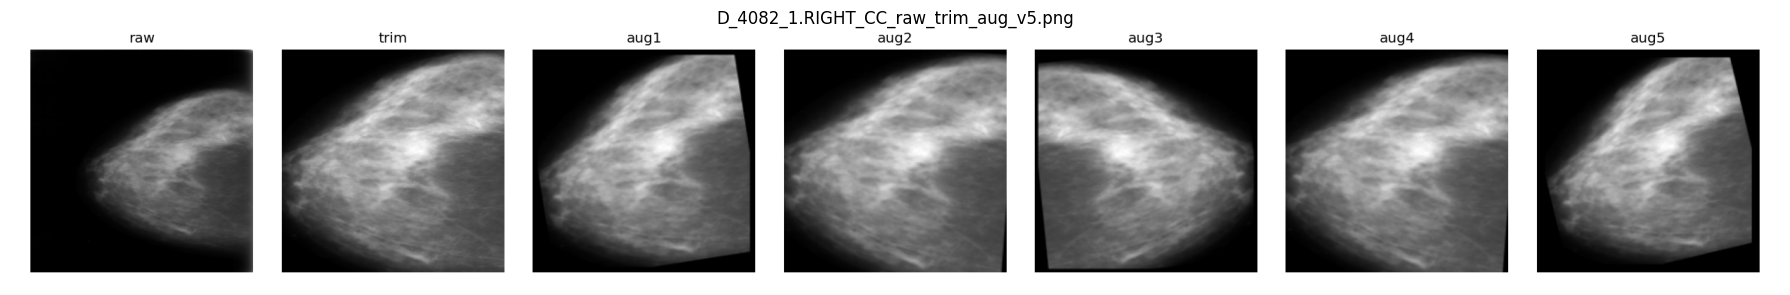

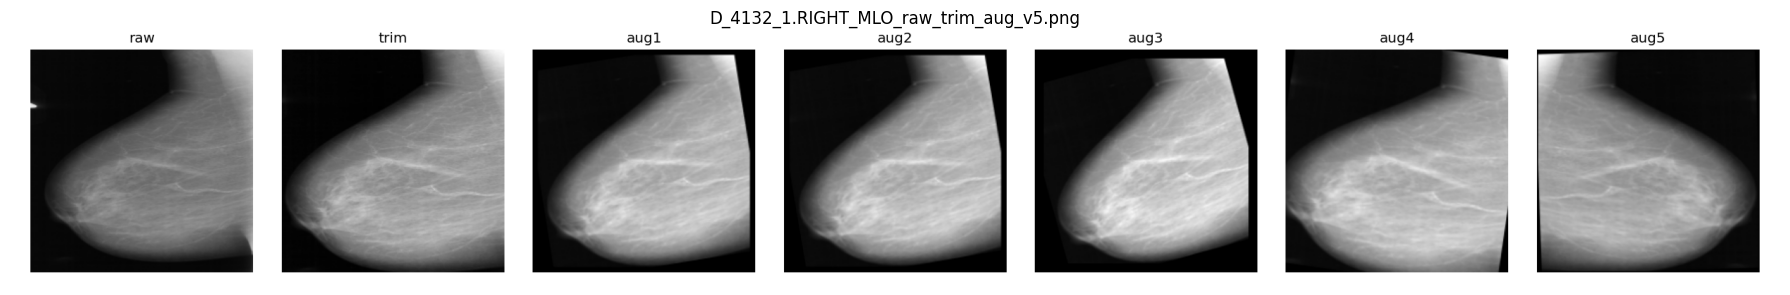

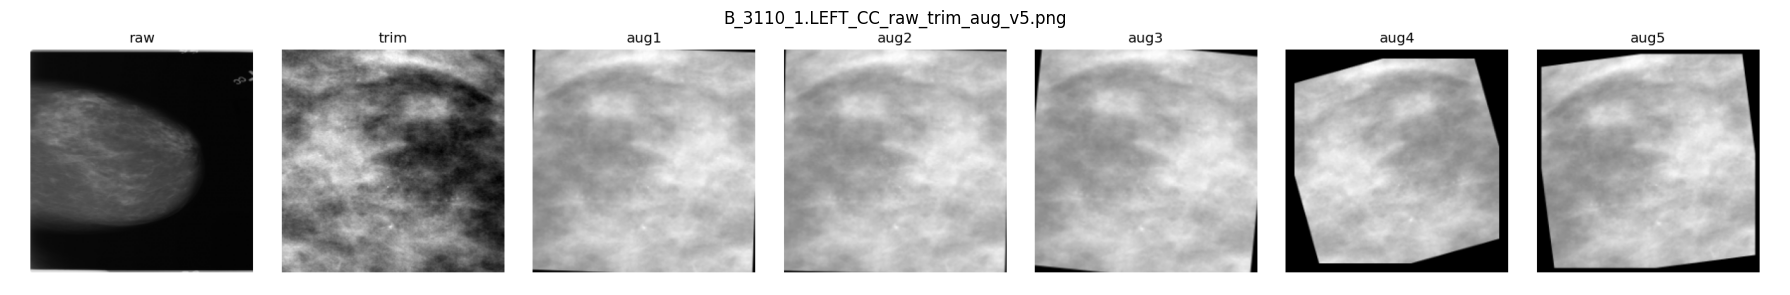

In [ ]:
# Cell 11 — Augmentation previews (v5)

preview_dir = VQC_DIR / "aug_previews_v5"
preview_dir.mkdir(parents=True, exist_ok=True)

N_IMAGES  = 8
N_AUGS    = 5
N_PREVIEW = 3

def _load_raw_gray_resized(path_str, size):
    img = cv2.imread(str(path_str), cv2.IMREAD_GRAYSCALE)
    if img is None: return None
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return (img / 255.0).astype("float32")

sample_rows = (
    train_df.sample(min(N_IMAGES, len(train_df)), random_state=SEED)
            [["image_path","resolved_mask_path","has_nonzero_mask"]]
            .to_dict("records")
)

saved, preview_paths = 0, []
for r in sample_rows:
    ip = r["image_path"]
    mp = r.get("resolved_mask_path") or ""
    hm = bool(r.get("has_nonzero_mask", False))

    raw = _load_raw_gray_resized(ip, IMG_SIZE)
    trimmed = _load_preprocess_numpy(ip, mp, hm)   # from Cell 10
    if raw is None or trimmed is None: 
        continue

    x0 = tf.convert_to_tensor(trimmed[None, ...], dtype=tf.float32)

    ims = [raw, to_disp(trimmed[..., 0])]
    for _ in range(N_AUGS):
        ims.append(to_disp(aug(x0, training=True)[0].numpy()[..., 0]))

    titles = ["raw", "trim"] + [f"aug{i+1}" for i in range(N_AUGS)]
    cols = len(ims)
    plt.figure(figsize=(3*cols, 3))
    for i, im in enumerate(ims):
        ax = plt.subplot(1, cols, i+1)
        ax.imshow(np.squeeze(im), cmap="gray", vmin=0, vmax=1)
        ax.set_axis_off(); ax.set_title(titles[i])
    out_path = preview_dir / (Path(ip).stem + "_raw_trim_aug_v5.png")
    plt.tight_layout(); plt.savefig(out_path, dpi=120); plt.close()

    if len(preview_paths) < N_PREVIEW:
        preview_paths.append(out_path)

    saved += 1

print(f"Saved {saved} raw/trim/aug grids ->", preview_dir)

# --- display each selected strip on its own line ---
for p in preview_paths:
    img = cv2.cvtColor(cv2.imread(str(p)), cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(18, 3))
    plt.imshow(img); plt.axis("off"); plt.title(Path(p).name)
    plt.tight_layout(); plt.show()

## 12: Model Build

In [ ]:
# Cell 12 — Model builder (v5)

def build_backbone(name, input_shape):
    if name.lower() == "vgg16":
        return VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    elif name.lower() == "resnet50":
        return ResNet50(weights="imagenet", include_top=False, input_shape=input_shape)
    else:
        raise ValueError("backbone not supported")

def build_model(name="vgg16"):
    base = build_backbone(name, IMG_SIZE + (3,))

    if name.lower() == "vgg16":
        for l in base.layers[:-4]:
            l.trainable = False
        unf = "unfrozen last 4 conv layers"
    else: 
        for l in base.layers[:-10]:
            l.trainable = False
        unf = "unfrozen last ~10 layers"

    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=regularizers.l2(1e-4))(x)
    x = layers.Dropout(0.3)(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=base.input, outputs=out, name=f"{name}_miniddsm_v5")
    return model, unf

def compile_model(model, lr=1e-4):
    opt = Adam(learning_rate=lr)
    model.compile(optimizer=opt,
                  loss="binary_crossentropy",
                  metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

WARMUP_EPOCHS = 8
es = EarlyStopping(
    monitor="val_auc", mode="max", patience=3, restore_best_weights=True, verbose=1
)


## 13: Warm-up Training (VGG16 vs ResNet50)

In [ ]:
# Cell 13 — Warm-up training (v5)

results = []

candidates = ["vgg16", "resnet50"]
for name in candidates:
    print(f"\n Warm-up training: {name.upper()} ")
    model, note = build_model(name)
    compile_model(model, lr=1e-4)

    ckpt_path = MODELS_DIR / f"tmp_{name}v5.keras"
    ckpt = ModelCheckpoint(
        filepath=str(ckpt_path),
        monitor="val_auc", mode="max",
        save_best_only=True, save_weights_only=False, verbose=1
    )
    ton = TerminateOnNaN()
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=WARMUP_EPOCHS,
        class_weight=class_weights,
        callbacks=[es, ckpt, ton],
        verbose=1,
    )

    # load best and eval on val
    best = tf.keras.models.load_model(ckpt_path)
    val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)

    results.append({
        "backbone": name,
        "val_loss": float(val_loss),
        "val_acc": float(val_acc),
        "val_auc": float(val_auc),
        "unfreeze_note": note
    })
    print(f"{name}: val_acc={val_acc:.3f}  val_auc={val_auc:.3f}  ({note})")

# pick the winner by val_auc
res_df = pd.DataFrame(results).sort_values("val_auc", ascending=False)
print("\n Warm-up results")
print(res_df.to_string(index=False))

# save table
cmp_path = METRICS_DIR / "baseline_compare_v5.csv"
res_df.to_csv(cmp_path, index=False)
print("\nSaved:", cmp_path)

best_name = res_df.iloc[0]["backbone"]
if best_name == "vgg16":
    last_conv = "block5_conv3"
else:
    last_conv = "conv5_block3_out"

# save the winner as our current best model
best_ckpt = MODELS_DIR / f"tmp_{best_name}v5.keras"
final_path = MODELS_DIR / "best_modelv5.keras"
Path(final_path).write_bytes(Path(best_ckpt).read_bytes())
print(f"\nWinner: {best_name.upper()}  | saved -> {final_path}")

CHOSEN_BACKBONE = best_name
CHOSEN_LAST_CONV = last_conv
print("Backbone:", CHOSEN_BACKBONE, "| Grad-CAM layer:", CHOSEN_LAST_CONV)


 Warm-up training: VGG16 
Epoch 1/8
509/656 [======================>.......] - ETA: 1:41 - loss: 0.7195 - accuracy: 0.6095 - auc: 0.6656

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6843 - accuracy: 0.6323 - auc: 0.6920
Epoch 1: val_auc improved from -inf to 0.44691, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/tmp_vgg16v5.keras
656/656 [==============================] - 573s 873ms/step - loss: 0.6843 - accuracy: 0.6323 - auc: 0.6920 - val_loss: 0.8614 - val_accuracy: 0.5515 - val_auc: 0.4469
Epoch 2/8
457/656 [===================>..........] - ETA: 2:16 - loss: 0.6580 - accuracy: 0.6242 - auc: 0.7040

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6061 - accuracy: 0.6622 - auc: 0.7434
Epoch 2: val_auc improved from 0.44691 to 0.46567, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/tmp_vgg16v5.keras
656/656 [==============================] - 569s 867ms/step - loss: 0.6061 - accuracy: 0.6622 - auc: 0.7434 - val_loss: 0.7440 - val_accuracy: 0.5412 - val_auc: 0.4657
Epoch 3/8
584/656 [=========================>....] - ETA: 49s - loss: 0.6244 - accuracy: 0.6453 - auc: 0.7282

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6113 - accuracy: 0.6561 - auc: 0.7392
Epoch 3: val_auc did not improve from 0.46567
656/656 [==============================] - 570s 868ms/step - loss: 0.6113 - accuracy: 0.6561 - auc: 0.7392 - val_loss: 0.8034 - val_accuracy: 0.5533 - val_auc: 0.4653
Epoch 4/8
589/656 [=========================>....] - ETA: 46s - loss: 0.6066 - accuracy: 0.6579 - auc: 0.7338

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5924 - accuracy: 0.6670 - auc: 0.7442
Epoch 4: val_auc improved from 0.46567 to 0.48711, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/tmp_vgg16v5.keras
656/656 [==============================] - 576s 878ms/step - loss: 0.5924 - accuracy: 0.6670 - auc: 0.7442 - val_loss: 0.8243 - val_accuracy: 0.5593 - val_auc: 0.4871
Epoch 5/8
416/656 [==================>...........] - ETA: 2:46 - loss: 0.6758 - accuracy: 0.6124 - auc: 0.6815

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6003 - accuracy: 0.6649 - auc: 0.7459
Epoch 5: val_auc did not improve from 0.48711
656/656 [==============================] - 570s 868ms/step - loss: 0.6003 - accuracy: 0.6649 - auc: 0.7459 - val_loss: 0.7649 - val_accuracy: 0.5436 - val_auc: 0.4769
Epoch 6/8
572/656 [=========================>....] - ETA: 56s - loss: 0.5831 - accuracy: 0.6733 - auc: 0.7628

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5684 - accuracy: 0.6845 - auc: 0.7769
Epoch 6: val_auc improved from 0.48711 to 0.50448, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/tmp_vgg16v5.keras
656/656 [==============================] - 564s 860ms/step - loss: 0.5684 - accuracy: 0.6845 - auc: 0.7769 - val_loss: 0.9027 - val_accuracy: 0.5569 - val_auc: 0.5045
Epoch 7/8
613/656 [===========================>..] - ETA: 29s - loss: 0.6051 - accuracy: 0.6576 - auc: 0.7484

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5917 - accuracy: 0.6662 - auc: 0.7588
Epoch 7: val_auc improved from 0.50448 to 0.53524, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/tmp_vgg16v5.keras
656/656 [==============================] - 565s 861ms/step - loss: 0.5917 - accuracy: 0.6662 - auc: 0.7588 - val_loss: 0.9981 - val_accuracy: 0.5551 - val_auc: 0.5352
Epoch 8/8
599/656 [==========================>...] - ETA: 38s - loss: 0.5772 - accuracy: 0.6607 - auc: 0.7622

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5628 - accuracy: 0.6725 - auc: 0.7738
Epoch 8: val_auc improved from 0.53524 to 0.57193, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/tmp_vgg16v5.keras
656/656 [==============================] - 564s 859ms/step - loss: 0.5628 - accuracy: 0.6725 - auc: 0.7738 - val_loss: 0.9404 - val_accuracy: 0.5551 - val_auc: 0.5719
vgg16: val_acc=0.555  val_auc=0.572  (unfrozen last 4 conv layers)

 Warm-up training: RESNET50 
Epoch 1/8
612/656 [==========================>...] - ETA: 28s - loss: 0.7128 - accuracy: 0.6083 - auc: 0.6671

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.7038 - accuracy: 0.6170 - auc: 0.6761
Epoch 1: val_auc improved from -inf to 0.48852, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/tmp_resnet50v5.keras
656/656 [==============================] - 537s 813ms/step - loss: 0.7038 - accuracy: 0.6170 - auc: 0.6761 - val_loss: 0.9516 - val_accuracy: 0.5109 - val_auc: 0.4885
Epoch 2/8
470/656 [====================>.........] - ETA: 1:59 - loss: 0.6942 - accuracy: 0.6008 - auc: 0.6784

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.6405 - auc: 0.7149
Epoch 2: val_auc did not improve from 0.48852
656/656 [==============================] - 530s 807ms/step - loss: 0.6556 - accuracy: 0.6405 - auc: 0.7149 - val_loss: 1.0165 - val_accuracy: 0.5381 - val_auc: 0.4830
Epoch 3/8
585/656 [=========================>....] - ETA: 45s - loss: 0.6664 - accuracy: 0.6293 - auc: 0.7006

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6542 - accuracy: 0.6397 - auc: 0.7099
Epoch 3: val_auc did not improve from 0.48852
656/656 [==============================] - 532s 810ms/step - loss: 0.6542 - accuracy: 0.6397 - auc: 0.7099 - val_loss: 0.8672 - val_accuracy: 0.4649 - val_auc: 0.4829
Epoch 4/8
513/656 [======================>.......] - ETA: 1:31 - loss: 0.6589 - accuracy: 0.6248 - auc: 0.7069

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.6454 - auc: 0.7218Restoring model weights from the end of the best epoch: 1.

Epoch 4: val_auc did not improve from 0.48852
656/656 [==============================] - 532s 810ms/step - loss: 0.6385 - accuracy: 0.6454 - auc: 0.7218 - val_loss: 0.8158 - val_accuracy: 0.4927 - val_auc: 0.4863
Epoch 4: early stopping
resnet50: val_acc=0.511  val_auc=0.489  (unfrozen last ~10 layers)

 Warm-up results
backbone  val_loss  val_acc  val_auc               unfreeze_note
   vgg16  0.940354 0.555085 0.571926 unfrozen last 4 conv layers
resnet50  0.951595 0.510896 0.488516    unfrozen last ~10 layers

Saved: /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/metrics/baseline_compare_v5.csv

Winner: VGG16  | saved -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_modelv5.keras
Backbone: vgg16 | Grad-CAM layer: block5_conv3


## 14:

In [ ]:
# Cell 14 — Full training (v5)

# paths
best_ckpt_v5   = MODELS_DIR / "best_model_v5.keras"
final_ckpt_path = MODELS_DIR / "best_model_full_v5.keras"

# load warm-up winner
src_ckpt = best_ckpt_v5
model = tf.keras.models.load_model(src_ckpt)

# compile
compile_model(model, lr=1e-4)

# callbacks
es  = EarlyStopping(monitor="val_auc", mode="max", patience=8, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
ckpt = ModelCheckpoint(filepath=str(final_ckpt_path), monitor="val_auc", mode="max", 
                       save_best_only=True, save_weights_only=False, verbose=1)
csv = CSVLogger(str(METRICS_DIR / "train_full_log_v5.csv"), append=False)
ton = TerminateOnNaN()

# train
EPOCHS_FULL = 50
hist = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FULL,
    class_weight=class_weights,
    callbacks=[es, rlr, ckpt, csv, ton],
    verbose=1,
)

# evaluate best
best = tf.keras.models.load_model(final_ckpt_path)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\nBest checkpoint -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved:", final_ckpt_path)

Loading: best_model.keras
Epoch 1/50
563/656 [========================>.....] - ETA: 1:03 - loss: 0.5997 - accuracy: 0.6701 - auc: 0.7445

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5804 - accuracy: 0.6805 - auc: 0.7579
Epoch 1: val_auc improved from -inf to 0.48553, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5.keras
656/656 [==============================] - 569s 866ms/step - loss: 0.5804 - accuracy: 0.6805 - auc: 0.7579 - val_loss: 0.8206 - val_accuracy: 0.5448 - val_auc: 0.4855 - lr: 1.0000e-04
Epoch 2/50
402/656 [=================>............] - ETA: 2:55 - loss: 0.6318 - accuracy: 0.6166 - auc: 0.7025

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.6729 - auc: 0.7633
Epoch 2: val_auc improved from 0.48553 to 0.49270, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5.keras
656/656 [==============================] - 570s 869ms/step - loss: 0.5623 - accuracy: 0.6729 - auc: 0.7633 - val_loss: 0.9942 - val_accuracy: 0.5484 - val_auc: 0.4927 - lr: 1.0000e-04
Epoch 3/50
613/656 [===========================>..] - ETA: 29s - loss: 0.5707 - accuracy: 0.6692 - auc: 0.7641

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5620 - accuracy: 0.6748 - auc: 0.7712
Epoch 3: val_auc improved from 0.49270 to 0.49307, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5.keras
656/656 [==============================] - 569s 867ms/step - loss: 0.5620 - accuracy: 0.6748 - auc: 0.7712 - val_loss: 1.3428 - val_accuracy: 0.5521 - val_auc: 0.4931 - lr: 1.0000e-04
Epoch 4/50
577/656 [=========================>....] - ETA: 53s - loss: 0.5768 - accuracy: 0.6605 - auc: 0.7609

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5567 - accuracy: 0.6714 - auc: 0.7735
Epoch 4: val_auc improved from 0.49307 to 0.51756, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5.keras
656/656 [==============================] - 569s 867ms/step - loss: 0.5567 - accuracy: 0.6714 - auc: 0.7735 - val_loss: 0.9612 - val_accuracy: 0.5454 - val_auc: 0.5176 - lr: 1.0000e-04
Epoch 5/50
566/656 [========================>.....] - ETA: 1:01 - loss: 0.5801 - accuracy: 0.6681 - auc: 0.7625

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5580 - accuracy: 0.6830 - auc: 0.7791
Epoch 5: val_auc improved from 0.51756 to 0.56379, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5.keras
656/656 [==============================] - 571s 870ms/step - loss: 0.5580 - accuracy: 0.6830 - auc: 0.7791 - val_loss: 0.7430 - val_accuracy: 0.5406 - val_auc: 0.5638 - lr: 1.0000e-04
Epoch 6/50
513/656 [======================>.......] - ETA: 1:37 - loss: 0.5763 - accuracy: 0.6538 - auc: 0.7559

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5340 - accuracy: 0.6838 - auc: 0.7902
Epoch 6: val_auc did not improve from 0.56379
656/656 [==============================] - 566s 863ms/step - loss: 0.5340 - accuracy: 0.6838 - auc: 0.7902 - val_loss: 0.8342 - val_accuracy: 0.5297 - val_auc: 0.5418 - lr: 1.0000e-04
Epoch 7/50
569/656 [=========================>....] - ETA: 59s - loss: 0.5558 - accuracy: 0.6920 - auc: 0.7923

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5402 - accuracy: 0.7026 - auc: 0.8012
Epoch 7: val_auc improved from 0.56379 to 0.57281, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5.keras
656/656 [==============================] - 574s 876ms/step - loss: 0.5402 - accuracy: 0.7026 - auc: 0.8012 - val_loss: 0.7735 - val_accuracy: 0.5478 - val_auc: 0.5728 - lr: 1.0000e-04
Epoch 8/50
399/656 [=================>............] - ETA: 4:28 - loss: 0.6160 - accuracy: 0.6382 - auc: 0.7413

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.6954 - auc: 0.8027
Epoch 8: val_auc improved from 0.57281 to 0.58015, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5.keras
656/656 [==============================] - 774s 1s/step - loss: 0.5283 - accuracy: 0.6954 - auc: 0.8027 - val_loss: 0.8042 - val_accuracy: 0.5551 - val_auc: 0.5802 - lr: 1.0000e-04
Epoch 9/50
474/656 [====================>.........] - ETA: 2:35 - loss: 0.5534 - accuracy: 0.6722 - auc: 0.7834

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5129 - accuracy: 0.7036 - auc: 0.8127
Epoch 9: val_auc did not improve from 0.58015
656/656 [==============================] - 703s 1s/step - loss: 0.5129 - accuracy: 0.7036 - auc: 0.8127 - val_loss: 0.8075 - val_accuracy: 0.5508 - val_auc: 0.5748 - lr: 1.0000e-04
Epoch 10/50
608/656 [==========================>...] - ETA: 38s - loss: 0.5170 - accuracy: 0.7095 - auc: 0.8155

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5072 - accuracy: 0.7148 - auc: 0.8211
Epoch 10: val_auc improved from 0.58015 to 0.61801, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5.keras
656/656 [==============================] - 635s 968ms/step - loss: 0.5072 - accuracy: 0.7148 - auc: 0.8211 - val_loss: 0.8897 - val_accuracy: 0.5702 - val_auc: 0.6180 - lr: 1.0000e-04
Epoch 11/50
629/656 [===========================>..] - ETA: 3:13 - loss: 0.5037 - accuracy: 0.7204 - auc: 0.8230

libpng error: Read Error


638/656 [============================>.] - ETA: 3:54 - loss: 0.5030 - accuracy: 0.7210 - auc: 0.8237

IOStream.flush timed out


656/656 [==============================] - ETA: 0s - loss: 0.4984 - accuracy: 0.7232 - auc: 0.8267 

In [ ]:
# Cell 14b — Resume full training (v5_resume)

# resume from checkpoint
src = MODELS_DIR / "best_model_full_v5.keras"
print("Resuming from:", src.name)
model = tf.keras.models.load_model(src)
compile_model(model, lr=1e-4)

# outputs
ckpt_out = MODELS_DIR / "best_model_full_v5_resume.keras"
csv_out  = METRICS_DIR / "train_full_log_v5.csv"

# callbacks
es  = EarlyStopping(monitor="val_auc", mode="max", patience=8, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-6, verbose=1)
ckpt = ModelCheckpoint(filepath=str(ckpt_out), monitor="val_auc", mode="max",
                       save_best_only=True, save_weights_only=False, verbose=1)
csv  = CSVLogger(str(csv_out), append=True)
ton  = TerminateOnNaN()

# train
EPOCHS_FULL_RESUME = 40
start_epoch = int(pd.read_csv(csv_out).shape[0]) if csv_out.exists() else 0

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_FULL_RESUME,
    initial_epoch=start_epoch,
    class_weight=class_weights,
    callbacks=[es, rlr, ckpt, csv, ton],
    verbose=1,
)

# evaluate best
best = tf.keras.models.load_model(ckpt_out)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\nResumed best -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved:", ckpt_out)

Resuming from: best_model_full_v5.keras
Epoch 11/40
613/656 [===========================>..] - ETA: 29s - loss: 0.5270 - accuracy: 0.7104 - auc: 0.8099

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.5189 - accuracy: 0.7148 - auc: 0.8160
Epoch 11: val_auc improved from -inf to 0.61283, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_resume.keras
656/656 [==============================] - 580s 882ms/step - loss: 0.5189 - accuracy: 0.7148 - auc: 0.8160 - val_loss: 0.8748 - val_accuracy: 0.5569 - val_auc: 0.6128 - lr: 1.0000e-04
Epoch 12/40
577/656 [=========================>....] - ETA: 54s - loss: 0.5114 - accuracy: 0.7255 - auc: 0.8252

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4908 - accuracy: 0.7379 - auc: 0.8360
Epoch 12: val_auc improved from 0.61283 to 0.61855, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_resume.keras
656/656 [==============================] - 570s 869ms/step - loss: 0.4908 - accuracy: 0.7379 - auc: 0.8360 - val_loss: 0.7755 - val_accuracy: 0.5769 - val_auc: 0.6186 - lr: 1.0000e-04
Epoch 13/40
566/656 [========================>.....] - ETA: 1:01 - loss: 0.5103 - accuracy: 0.7217 - auc: 0.8225

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4899 - accuracy: 0.7314 - auc: 0.8340
Epoch 13: val_auc improved from 0.61855 to 0.62245, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_resume.keras
656/656 [==============================] - 567s 864ms/step - loss: 0.4899 - accuracy: 0.7314 - auc: 0.8340 - val_loss: 0.7624 - val_accuracy: 0.5860 - val_auc: 0.6224 - lr: 1.0000e-04
Epoch 14/40
513/656 [======================>.......] - ETA: 1:38 - loss: 0.5211 - accuracy: 0.7071 - auc: 0.8135

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4860 - accuracy: 0.7274 - auc: 0.8356
Epoch 14: val_auc did not improve from 0.62245
656/656 [==============================] - 570s 869ms/step - loss: 0.4860 - accuracy: 0.7274 - auc: 0.8356 - val_loss: 0.7712 - val_accuracy: 0.5708 - val_auc: 0.6099 - lr: 1.0000e-04
Epoch 15/40
569/656 [=========================>....] - ETA: 59s - loss: 0.5037 - accuracy: 0.7322 - auc: 0.8354 

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4899 - accuracy: 0.7371 - auc: 0.8412
Epoch 15: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 15: val_auc did not improve from 0.62245
656/656 [==============================] - 571s 870ms/step - loss: 0.4899 - accuracy: 0.7371 - auc: 0.8412 - val_loss: 0.7388 - val_accuracy: 0.5623 - val_auc: 0.6042 - lr: 1.0000e-04
Epoch 16/40
399/656 [=================>............] - ETA: 2:57 - loss: 0.5493 - accuracy: 0.6933 - auc: 0.7974

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4678 - accuracy: 0.7440 - auc: 0.8482
Epoch 16: val_auc improved from 0.62245 to 0.63658, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_resume.keras
656/656 [==============================] - 578s 882ms/step - loss: 0.4678 - accuracy: 0.7440 - auc: 0.8482 - val_loss: 0.7147 - val_accuracy: 0.6035 - val_auc: 0.6366 - lr: 5.0000e-05
Epoch 17/40
474/656 [====================>.........] - ETA: 2:08 - loss: 0.4848 - accuracy: 0.7302 - auc: 0.8419

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4527 - accuracy: 0.7499 - auc: 0.8598
Epoch 17: val_auc did not improve from 0.63658
656/656 [==============================] - 590s 900ms/step - loss: 0.4527 - accuracy: 0.7499 - auc: 0.8598 - val_loss: 0.7290 - val_accuracy: 0.5860 - val_auc: 0.6355 - lr: 5.0000e-05
Epoch 18/40
608/656 [==========================>...] - ETA: 32s - loss: 0.4543 - accuracy: 0.7590 - auc: 0.8638

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4456 - accuracy: 0.7640 - auc: 0.8681
Epoch 18: val_auc improved from 0.63658 to 0.64317, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_resume.keras
656/656 [==============================] - 570s 868ms/step - loss: 0.4456 - accuracy: 0.7640 - auc: 0.8681 - val_loss: 0.7829 - val_accuracy: 0.6071 - val_auc: 0.6432 - lr: 5.0000e-05
Epoch 19/40
630/656 [===========================>..] - ETA: 17s - loss: 0.4516 - accuracy: 0.7696 - auc: 0.8659

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4443 - accuracy: 0.7745 - auc: 0.8703
Epoch 19: val_auc did not improve from 0.64317
656/656 [==============================] - 569s 868ms/step - loss: 0.4443 - accuracy: 0.7745 - auc: 0.8703 - val_loss: 0.7866 - val_accuracy: 0.6132 - val_auc: 0.6396 - lr: 5.0000e-05
Epoch 20/40
407/656 [=================>............] - ETA: 2:48 - loss: 0.4945 - accuracy: 0.7436 - auc: 0.8428

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4307 - accuracy: 0.7796 - auc: 0.8764
Epoch 20: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 20: val_auc did not improve from 0.64317
656/656 [==============================] - 561s 854ms/step - loss: 0.4307 - accuracy: 0.7796 - auc: 0.8764 - val_loss: 0.7527 - val_accuracy: 0.5956 - val_auc: 0.6297 - lr: 5.0000e-05
Epoch 21/40
647/656 [============================>.] - ETA: 6s - loss: 0.4130 - accuracy: 0.7883 - auc: 0.8874

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4118 - accuracy: 0.7886 - auc: 0.8880
Epoch 21: val_auc did not improve from 0.64317
656/656 [==============================] - 560s 853ms/step - loss: 0.4118 - accuracy: 0.7886 - auc: 0.8880 - val_loss: 0.9062 - val_accuracy: 0.5908 - val_auc: 0.6294 - lr: 2.5000e-05
Epoch 22/40
455/656 [===================>..........] - ETA: 2:16 - loss: 0.4567 - accuracy: 0.7706 - auc: 0.8682

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.7979 - auc: 0.8915
Epoch 22: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 22: val_auc did not improve from 0.64317
656/656 [==============================] - 564s 859ms/step - loss: 0.4073 - accuracy: 0.7979 - auc: 0.8915 - val_loss: 0.9344 - val_accuracy: 0.5799 - val_auc: 0.6277 - lr: 2.5000e-05
Epoch 23/40
481/656 [====================>.........] - ETA: 1:59 - loss: 0.4347 - accuracy: 0.7877 - auc: 0.8801

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3955 - accuracy: 0.8061 - auc: 0.8980
Epoch 23: val_auc did not improve from 0.64317
656/656 [==============================] - 564s 860ms/step - loss: 0.3955 - accuracy: 0.8061 - auc: 0.8980 - val_loss: 0.9485 - val_accuracy: 0.5751 - val_auc: 0.6270 - lr: 1.2500e-05
Epoch 24/40
479/656 [====================>.........] - ETA: 2:02 - loss: 0.4206 - accuracy: 0.7962 - auc: 0.8897

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3860 - accuracy: 0.8090 - auc: 0.9032
Epoch 24: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 24: val_auc did not improve from 0.64317
656/656 [==============================] - 571s 870ms/step - loss: 0.3860 - accuracy: 0.8090 - auc: 0.9032 - val_loss: 0.9175 - val_accuracy: 0.5769 - val_auc: 0.6332 - lr: 1.2500e-05
Epoch 25/40
623/656 [===========================>..] - ETA: 22s - loss: 0.3975 - accuracy: 0.8062 - auc: 0.8984

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3915 - accuracy: 0.8096 - auc: 0.9013
Epoch 25: val_auc did not improve from 0.64317
656/656 [==============================] - 566s 862ms/step - loss: 0.3915 - accuracy: 0.8096 - auc: 0.9013 - val_loss: 0.9267 - val_accuracy: 0.5769 - val_auc: 0.6321 - lr: 6.2500e-06
Epoch 26/40
506/656 [======================>.......] - ETA: 1:46 - loss: 0.4277 - accuracy: 0.7838 - auc: 0.8819

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3909 - accuracy: 0.8039 - auc: 0.8996Restoring model weights from the end of the best epoch: 18.

Epoch 26: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 26: val_auc did not improve from 0.64317
656/656 [==============================] - 579s 883ms/step - loss: 0.3909 - accuracy: 0.8039 - auc: 0.8996 - val_loss: 0.9242 - val_accuracy: 0.5854 - val_auc: 0.6324 - lr: 6.2500e-06
Epoch 26: early stopping

Resumed best -> val_acc=0.607  val_auc=0.643
Saved: /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_resume.keras


In [ ]:
# Cell 14c — Fine-tune (v5_finetune)

src = MODELS_DIR / "best_model_full_v5_resume.keras"
print("Fine-tuning from:", src.name)
model = tf.keras.models.load_model(src)

def unfreeze_more_conv_layers(m, extra_conv=8):
    conv_layers = [l for l in m.layers if isinstance(l, Conv2D)]
    for l in conv_layers[-extra_conv:]:
        l.trainable = True
    for l in m.layers:
        if isinstance(l, (Dense, Dropout, GlobalAveragePooling2D)):
            l.trainable = True
    print("Conv2D trainable:", sum(int(l.trainable) for l in conv_layers), "/", len(conv_layers))

unfreeze_more_conv_layers(model, extra_conv=8)

model.compile(
    optimizer=Adam(learning_rate=5e-6, clipnorm=1.0),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

ckpt_out = MODELS_DIR / "best_model_full_v5_finetune.keras"
csv_out  = METRICS_DIR / "train_full_log_v5_finetune.csv"

es  = EarlyStopping(monitor="val_auc", mode="max", patience=6, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-7, verbose=1)
ckpt = ModelCheckpoint(filepath=str(ckpt_out), monitor="val_auc", mode="max",
                       save_best_only=True, save_weights_only=False, verbose=1)
csv = CSVLogger(str(csv_out), append=False)
ton = TerminateOnNaN()

FT_EPOCHS = 30
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT_EPOCHS,
    class_weight=class_weights,
    callbacks=[es, rlr, ckpt, csv, ton],
    verbose=1,
)

best = tf.keras.models.load_model(ckpt_out)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\nFine-tuned best -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved:", ckpt_out)

Fine-tuning from: best_model_full_v5_resume.keras
Conv2D trainable: 8 / 13
Epoch 1/30
567/656 [========================>.....] - ETA: 1:13 - loss: 0.4981 - accuracy: 0.7560 - auc: 0.8480

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4758 - accuracy: 0.7669 - auc: 0.8589
Epoch 1: val_auc improved from -inf to 0.62135, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_finetune.keras
656/656 [==============================] - 664s 1s/step - loss: 0.4758 - accuracy: 0.7669 - auc: 0.8589 - val_loss: 0.8528 - val_accuracy: 0.5920 - val_auc: 0.6214 - lr: 5.0000e-06
Epoch 2/30
566/656 [========================>.....] - ETA: 1:14 - loss: 0.4890 - accuracy: 0.7575 - auc: 0.8546

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4672 - accuracy: 0.7693 - auc: 0.8650
Epoch 2: val_auc improved from 0.62135 to 0.63327, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_finetune.keras
656/656 [==============================] - 658s 1s/step - loss: 0.4672 - accuracy: 0.7693 - auc: 0.8650 - val_loss: 0.8647 - val_accuracy: 0.5872 - val_auc: 0.6333 - lr: 5.0000e-06
Epoch 3/30
509/656 [======================>.......] - ETA: 2:01 - loss: 0.4859 - accuracy: 0.7726 - auc: 0.8582

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4541 - accuracy: 0.7865 - auc: 0.8735
Epoch 3: val_auc improved from 0.63327 to 0.64041, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_finetune.keras
656/656 [==============================] - 661s 1s/step - loss: 0.4541 - accuracy: 0.7865 - auc: 0.8735 - val_loss: 0.7881 - val_accuracy: 0.6041 - val_auc: 0.6404 - lr: 5.0000e-06
Epoch 4/30
457/656 [===================>..........] - ETA: 2:44 - loss: 0.4965 - accuracy: 0.7497 - auc: 0.8489

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4411 - accuracy: 0.7789 - auc: 0.8757
Epoch 4: val_auc did not improve from 0.64041
656/656 [==============================] - 662s 1s/step - loss: 0.4411 - accuracy: 0.7789 - auc: 0.8757 - val_loss: 0.8623 - val_accuracy: 0.5987 - val_auc: 0.6367 - lr: 5.0000e-06
Epoch 5/30
584/656 [=========================>....] - ETA: 59s - loss: 0.4365 - accuracy: 0.7892 - auc: 0.8805 

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4249 - accuracy: 0.7934 - auc: 0.8853
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 5: val_auc did not improve from 0.64041
656/656 [==============================] - 661s 1s/step - loss: 0.4249 - accuracy: 0.7934 - auc: 0.8853 - val_loss: 0.8246 - val_accuracy: 0.5944 - val_auc: 0.6379 - lr: 5.0000e-06
Epoch 6/30
588/656 [=========================>....] - ETA: 56s - loss: 0.4132 - accuracy: 0.7959 - auc: 0.8891

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4063 - accuracy: 0.8014 - auc: 0.8929
Epoch 6: val_auc did not improve from 0.64041
656/656 [==============================] - 662s 1s/step - loss: 0.4063 - accuracy: 0.8014 - auc: 0.8929 - val_loss: 0.9573 - val_accuracy: 0.5975 - val_auc: 0.6393 - lr: 2.5000e-06
Epoch 7/30
415/656 [=================>............] - ETA: 3:19 - loss: 0.4660 - accuracy: 0.7843 - auc: 0.8689

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.8126 - auc: 0.8973
Epoch 7: val_auc improved from 0.64041 to 0.64214, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_finetune.keras
656/656 [==============================] - 661s 1s/step - loss: 0.4065 - accuracy: 0.8126 - auc: 0.8973 - val_loss: 0.9509 - val_accuracy: 0.6071 - val_auc: 0.6421 - lr: 2.5000e-06
Epoch 8/30
572/656 [=========================>....] - ETA: 1:09 - loss: 0.4086 - accuracy: 0.7992 - auc: 0.8930

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3936 - accuracy: 0.8080 - auc: 0.9004
Epoch 8: val_auc improved from 0.64214 to 0.64369, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_finetune.keras
656/656 [==============================] - 661s 1s/step - loss: 0.3936 - accuracy: 0.8080 - auc: 0.9004 - val_loss: 0.9392 - val_accuracy: 0.6090 - val_auc: 0.6437 - lr: 2.5000e-06
Epoch 9/30
613/656 [===========================>..] - ETA: 35s - loss: 0.4091 - accuracy: 0.8077 - auc: 0.8952

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3992 - accuracy: 0.8115 - auc: 0.8995
Epoch 9: val_auc did not improve from 0.64369
656/656 [==============================] - 662s 1s/step - loss: 0.3992 - accuracy: 0.8115 - auc: 0.8995 - val_loss: 1.0580 - val_accuracy: 0.5890 - val_auc: 0.6422 - lr: 2.5000e-06
Epoch 10/30
598/656 [==========================>...] - ETA: 47s - loss: 0.3947 - accuracy: 0.8175 - auc: 0.9022

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3840 - accuracy: 0.8237 - auc: 0.9073
Epoch 10: val_auc improved from 0.64369 to 0.64386, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_finetune.keras
656/656 [==============================] - 661s 1s/step - loss: 0.3840 - accuracy: 0.8237 - auc: 0.9073 - val_loss: 1.0369 - val_accuracy: 0.5920 - val_auc: 0.6439 - lr: 2.5000e-06
Epoch 11/30
509/656 [======================>.......] - ETA: 2:01 - loss: 0.4128 - accuracy: 0.8089 - auc: 0.8981

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3873 - accuracy: 0.8183 - auc: 0.9077
Epoch 11: val_auc did not improve from 0.64386
656/656 [==============================] - 660s 1s/step - loss: 0.3873 - accuracy: 0.8183 - auc: 0.9077 - val_loss: 0.9266 - val_accuracy: 0.5829 - val_auc: 0.6397 - lr: 2.5000e-06
Epoch 12/30
612/656 [==========================>...] - ETA: 36s - loss: 0.3781 - accuracy: 0.8346 - auc: 0.9109

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3678 - accuracy: 0.8387 - auc: 0.9153
Epoch 12: val_auc improved from 0.64386 to 0.64457, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_finetune.keras
656/656 [==============================] - 661s 1s/step - loss: 0.3678 - accuracy: 0.8387 - auc: 0.9153 - val_loss: 1.0998 - val_accuracy: 0.6102 - val_auc: 0.6446 - lr: 2.5000e-06
Epoch 13/30
470/656 [====================>.........] - ETA: 2:33 - loss: 0.4117 - accuracy: 0.8027 - auc: 0.8953

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3784 - accuracy: 0.8225 - auc: 0.9102
Epoch 13: val_auc improved from 0.64457 to 0.65042, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_finetune.keras
656/656 [==============================] - 662s 1s/step - loss: 0.3784 - accuracy: 0.8225 - auc: 0.9102 - val_loss: 0.9613 - val_accuracy: 0.6108 - val_auc: 0.6504 - lr: 2.5000e-06
Epoch 14/30
584/656 [=========================>....] - ETA: 59s - loss: 0.3905 - accuracy: 0.8311 - auc: 0.9102 

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3802 - accuracy: 0.8357 - auc: 0.9138
Epoch 14: val_auc did not improve from 0.65042
656/656 [==============================] - 661s 1s/step - loss: 0.3802 - accuracy: 0.8357 - auc: 0.9138 - val_loss: 1.3173 - val_accuracy: 0.5714 - val_auc: 0.6292 - lr: 2.5000e-06
Epoch 15/30
512/656 [======================>.......] - ETA: 1:58 - loss: 0.3887 - accuracy: 0.8215 - auc: 0.9090

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3611 - accuracy: 0.8349 - auc: 0.9196
Epoch 15: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 15: val_auc did not improve from 0.65042
656/656 [==============================] - 660s 1s/step - loss: 0.3611 - accuracy: 0.8349 - auc: 0.9196 - val_loss: 1.0821 - val_accuracy: 0.6192 - val_auc: 0.6497 - lr: 2.5000e-06
Epoch 16/30
440/656 [===================>..........] - ETA: 2:59 - loss: 0.4092 - accuracy: 0.8131 - auc: 0.9007

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3643 - accuracy: 0.8364 - auc: 0.9187
Epoch 16: val_auc did not improve from 0.65042
656/656 [==============================] - 661s 1s/step - loss: 0.3643 - accuracy: 0.8364 - auc: 0.9187 - val_loss: 1.1449 - val_accuracy: 0.5829 - val_auc: 0.6404 - lr: 1.2500e-06
Epoch 17/30
625/656 [===========================>..] - ETA: 25s - loss: 0.3551 - accuracy: 0.8452 - auc: 0.9231

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3527 - accuracy: 0.8467 - auc: 0.9243
Epoch 17: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 17: val_auc did not improve from 0.65042
656/656 [==============================] - 662s 1s/step - loss: 0.3527 - accuracy: 0.8467 - auc: 0.9243 - val_loss: 1.0587 - val_accuracy: 0.5993 - val_auc: 0.6469 - lr: 1.2500e-06
Epoch 18/30
596/656 [==========================>...] - ETA: 49s - loss: 0.3439 - accuracy: 0.8435 - auc: 0.9257

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3351 - accuracy: 0.8479 - auc: 0.9290
Epoch 18: val_auc did not improve from 0.65042
656/656 [==============================] - 661s 1s/step - loss: 0.3351 - accuracy: 0.8479 - auc: 0.9290 - val_loss: 1.1549 - val_accuracy: 0.5884 - val_auc: 0.6414 - lr: 6.2500e-07
Epoch 19/30
563/656 [========================>.....] - ETA: 1:17 - loss: 0.3552 - accuracy: 0.8395 - auc: 0.9219

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3379 - accuracy: 0.8483 - auc: 0.9282Restoring model weights from the end of the best epoch: 13.

Epoch 19: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-07.

Epoch 19: val_auc did not improve from 0.65042
656/656 [==============================] - 666s 1s/step - loss: 0.3379 - accuracy: 0.8483 - auc: 0.9282 - val_loss: 1.1563 - val_accuracy: 0.5896 - val_auc: 0.6450 - lr: 6.2500e-07
Epoch 19: early stopping

Fine-tuned best -> val_acc=0.611  val_auc=0.650
Saved: /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_finetune.keras


In [ ]:
# Cell 14d — Fine-tune (v5_finetune_resume)

src = MODELS_DIR / "best_model_full_v5_finetune.keras"
print("Fine-tuning from:", src.name)
model = tf.keras.models.load_model(src)

def unfreeze_more_conv_layers(m, extra_conv=10):
    conv_layers = [l for l in m.layers if isinstance(l, tf.keras.layers.Conv2D)]
    for l in conv_layers[-extra_conv:]:
        l.trainable = True
    for l in m.layers:
        if isinstance(l, (tf.keras.layers.Dense,
                          tf.keras.layers.Dropout,
                          tf.keras.layers.GlobalAveragePooling2D)):
            l.trainable = True
    print("Conv2D trainable:", sum(int(l.trainable) for l in conv_layers), "/", len(conv_layers))

unfreeze_more_conv_layers(model, extra_conv=10)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-6, clipnorm=1.0),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

ckpt_out = MODELS_DIR / "best_model_full_v5_finetune_resume.keras"
csv_out  = METRICS_DIR / "train_full_log_v5_finetune_resume.csv"

es  = tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=6, restore_best_weights=True, verbose=1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-7, verbose=1)
ckpt = tf.keras.callbacks.ModelCheckpoint(filepath=str(ckpt_out), monitor="val_auc", mode="max",
                                          save_best_only=True, save_weights_only=False, verbose=1)
csv = tf.keras.callbacks.CSVLogger(str(csv_out), append=False)
ton = tf.keras.callbacks.TerminateOnNaN()

FT_EPOCHS = 30
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT_EPOCHS,
    class_weight=class_weights,
    callbacks=[es, rlr, ckpt, csv, ton],
    verbose=1,
)

best = tf.keras.models.load_model(ckpt_out)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\nFine-tuned best -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved:", ckpt_out)

Fine-tuning from: best_model_full_v5_finetune.keras
Conv2D trainable: 10 / 13
Epoch 1/30
567/656 [========================>.....] - ETA: 1:22 - loss: 0.4212 - accuracy: 0.8146 - auc: 0.8954

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.8229 - auc: 0.9041
Epoch 1: val_auc improved from -inf to 0.64689, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_finetune_resume.keras
656/656 [==============================] - 728s 1s/step - loss: 0.3998 - accuracy: 0.8229 - auc: 0.9041 - val_loss: 1.0631 - val_accuracy: 0.6102 - val_auc: 0.6469 - lr: 5.0000e-06
Epoch 2/30
566/656 [========================>.....] - ETA: 1:22 - loss: 0.4067 - accuracy: 0.8134 - auc: 0.9026

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3882 - accuracy: 0.8218 - auc: 0.9096
Epoch 2: val_auc improved from 0.64689 to 0.64931, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_finetune_resume.keras
656/656 [==============================] - 723s 1s/step - loss: 0.3882 - accuracy: 0.8218 - auc: 0.9096 - val_loss: 1.1025 - val_accuracy: 0.5938 - val_auc: 0.6493 - lr: 5.0000e-06
Epoch 3/30
509/656 [======================>.......] - ETA: 2:16 - loss: 0.4146 - accuracy: 0.8229 - auc: 0.9023

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3823 - accuracy: 0.8359 - auc: 0.9147
Epoch 3: val_auc did not improve from 0.64931
656/656 [==============================] - 732s 1s/step - loss: 0.3823 - accuracy: 0.8359 - auc: 0.9147 - val_loss: 1.0941 - val_accuracy: 0.5805 - val_auc: 0.6401 - lr: 5.0000e-06
Epoch 4/30
457/656 [===================>..........] - ETA: 3:06 - loss: 0.4180 - accuracy: 0.8110 - auc: 0.8980

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3692 - accuracy: 0.8347 - auc: 0.9171
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 4: val_auc did not improve from 0.64931
656/656 [==============================] - 728s 1s/step - loss: 0.3692 - accuracy: 0.8347 - auc: 0.9171 - val_loss: 1.1025 - val_accuracy: 0.5890 - val_auc: 0.6335 - lr: 5.0000e-06
Epoch 5/30
584/656 [=========================>....] - ETA: 1:07 - loss: 0.3382 - accuracy: 0.8568 - auc: 0.9308

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3278 - accuracy: 0.8597 - auc: 0.9342
Epoch 5: val_auc did not improve from 0.64931
656/656 [==============================] - 742s 1s/step - loss: 0.3278 - accuracy: 0.8597 - auc: 0.9342 - val_loss: 1.1540 - val_accuracy: 0.5775 - val_auc: 0.6357 - lr: 2.5000e-06
Epoch 6/30
588/656 [=========================>....] - ETA: 1:03 - loss: 0.3384 - accuracy: 0.8491 - auc: 0.9289

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3346 - accuracy: 0.8534 - auc: 0.9308
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 6: val_auc did not improve from 0.64931
656/656 [==============================] - 735s 1s/step - loss: 0.3346 - accuracy: 0.8534 - auc: 0.9308 - val_loss: 1.4052 - val_accuracy: 0.5920 - val_auc: 0.6269 - lr: 2.5000e-06
Epoch 7/30
415/656 [=================>............] - ETA: 3:44 - loss: 0.3701 - accuracy: 0.8425 - auc: 0.9201

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3242 - accuracy: 0.8637 - auc: 0.9369
Epoch 7: val_auc did not improve from 0.64931
656/656 [==============================] - 729s 1s/step - loss: 0.3242 - accuracy: 0.8637 - auc: 0.9369 - val_loss: 1.4675 - val_accuracy: 0.5720 - val_auc: 0.6316 - lr: 1.2500e-06
Epoch 8/30
572/656 [=========================>....] - ETA: 1:17 - loss: 0.3167 - accuracy: 0.8628 - auc: 0.9387

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.3034 - accuracy: 0.8694 - auc: 0.9433Restoring model weights from the end of the best epoch: 2.

Epoch 8: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 8: val_auc did not improve from 0.64931
656/656 [==============================] - 726s 1s/step - loss: 0.3034 - accuracy: 0.8694 - auc: 0.9433 - val_loss: 1.3392 - val_accuracy: 0.5787 - val_auc: 0.6365 - lr: 1.2500e-06
Epoch 8: early stopping

Fine-tuned best -> val_acc=0.594  val_auc=0.649
Saved: /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/best_model_full_v5_finetune_resume.keras


In [ ]:
# Cell 14e — ResNet50 fine-tune (v5_finetune)

src = MODELS_DIR / "tmp_resnet50v5.keras"
print("Fine-tuning from:", src.name)
model = tf.keras.models.load_model(src)

def unfreeze_more_conv_layers(m, extra_conv=12):
    convs = [l for l in m.layers if isinstance(l, tf.keras.layers.Conv2D)]
    for l in convs[-extra_conv:]:
        l.trainable = True
    for l in m.layers:
        if isinstance(l, (tf.keras.layers.Dense,
                          tf.keras.layers.Dropout,
                          tf.keras.layers.GlobalAveragePooling2D)):
            l.trainable = True
    print("Conv2D trainable:", sum(int(l.trainable) for l in convs), "/", len(convs))

unfreeze_more_conv_layers(model, extra_conv=12)

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-6, clipnorm=1.0),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

ckpt_out = MODELS_DIR / "resnet50_full_v5_finetune.keras"
csv_out  = METRICS_DIR / "resnet50_v5_finetune.csv"

es  = tf.keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=6, restore_best_weights=True, verbose=1)
ckpt = tf.keras.callbacks.ModelCheckpoint(filepath=str(ckpt_out), monitor="val_auc", mode="max",
                                          save_best_only=True, save_weights_only=False, verbose=1)
csv = tf.keras.callbacks.CSVLogger(str(csv_out), append=False)
ton = tf.keras.callbacks.TerminateOnNaN()

FT_EPOCHS = 50
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT_EPOCHS,
    class_weight=class_weights,
    callbacks=[es, ckpt, csv, ton],
    verbose=1,
)

best = tf.keras.models.load_model(ckpt_out)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\nResNet50 fine-tuned -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved best checkpoint ->", ckpt_out)

Fine-tuning from: tmp_resnet50v5.keras
Conv2D trainable: 12 / 53
Epoch 1/50
585/656 [=========================>....] - ETA: 46s - loss: 0.6923 - accuracy: 0.6408 - auc: 0.6891

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6778 - accuracy: 0.6531 - auc: 0.6995
Epoch 1: val_auc improved from -inf to 0.47565, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/resnet50_full_v5_finetune.keras
656/656 [==============================] - 549s 830ms/step - loss: 0.6778 - accuracy: 0.6531 - auc: 0.6995 - val_loss: 1.3569 - val_accuracy: 0.4558 - val_auc: 0.4757
Epoch 2/50
513/656 [======================>.......] - ETA: 1:31 - loss: 0.6761 - accuracy: 0.6425 - auc: 0.7080

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.6607 - auc: 0.7231
Epoch 2: val_auc improved from 0.47565 to 0.48736, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/resnet50_full_v5_finetune.keras
656/656 [==============================] - 531s 809ms/step - loss: 0.6528 - accuracy: 0.6607 - auc: 0.7231 - val_loss: 0.9601 - val_accuracy: 0.4873 - val_auc: 0.4874
Epoch 3/50
441/656 [===================>..........] - ETA: 2:19 - loss: 0.6948 - accuracy: 0.6264 - auc: 0.6887

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6482 - accuracy: 0.6674 - auc: 0.7250
Epoch 3: val_auc improved from 0.48736 to 0.49321, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/resnet50_full_v5_finetune.keras
656/656 [==============================] - 537s 818ms/step - loss: 0.6482 - accuracy: 0.6674 - auc: 0.7250 - val_loss: 0.9454 - val_accuracy: 0.4818 - val_auc: 0.4932
Epoch 4/50
625/656 [===========================>..] - ETA: 20s - loss: 0.6483 - accuracy: 0.6654 - auc: 0.7269

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.6687 - auc: 0.7307
Epoch 4: val_auc improved from 0.49321 to 0.51508, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/resnet50_full_v5_finetune.keras
656/656 [==============================] - 538s 820ms/step - loss: 0.6447 - accuracy: 0.6687 - auc: 0.7307 - val_loss: 0.9366 - val_accuracy: 0.5527 - val_auc: 0.5151
Epoch 5/50
596/656 [==========================>...] - ETA: 39s - loss: 0.6490 - accuracy: 0.6655 - auc: 0.7278

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6397 - accuracy: 0.6710 - auc: 0.7342
Epoch 5: val_auc did not improve from 0.51508
656/656 [==============================] - 543s 827ms/step - loss: 0.6397 - accuracy: 0.6710 - auc: 0.7342 - val_loss: 0.9736 - val_accuracy: 0.5091 - val_auc: 0.5005
Epoch 6/50
563/656 [========================>.....] - ETA: 1:01 - loss: 0.6614 - accuracy: 0.6570 - auc: 0.7161

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6447 - accuracy: 0.6704 - auc: 0.7289
Epoch 6: val_auc did not improve from 0.51508
656/656 [==============================] - 544s 830ms/step - loss: 0.6447 - accuracy: 0.6704 - auc: 0.7289 - val_loss: 0.8973 - val_accuracy: 0.5242 - val_auc: 0.5066
Epoch 7/50
402/656 [=================>............] - ETA: 2:48 - loss: 0.6979 - accuracy: 0.6213 - auc: 0.6865

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6416 - accuracy: 0.6721 - auc: 0.7301
Epoch 7: val_auc improved from 0.51508 to 0.52210, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/resnet50_full_v5_finetune.keras
656/656 [==============================] - 543s 828ms/step - loss: 0.6416 - accuracy: 0.6721 - auc: 0.7301 - val_loss: 0.8494 - val_accuracy: 0.5460 - val_auc: 0.5221
Epoch 8/50
613/656 [===========================>..] - ETA: 28s - loss: 0.6512 - accuracy: 0.6631 - auc: 0.7254

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6428 - accuracy: 0.6708 - auc: 0.7335
Epoch 8: val_auc did not improve from 0.52210
656/656 [==============================] - 542s 826ms/step - loss: 0.6428 - accuracy: 0.6708 - auc: 0.7335 - val_loss: 0.9534 - val_accuracy: 0.5375 - val_auc: 0.5171
Epoch 9/50
577/656 [=========================>....] - ETA: 51s - loss: 0.6488 - accuracy: 0.6601 - auc: 0.7283

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6337 - accuracy: 0.6727 - auc: 0.7385
Epoch 9: val_auc did not improve from 0.52210
656/656 [==============================] - 542s 827ms/step - loss: 0.6337 - accuracy: 0.6727 - auc: 0.7385 - val_loss: 0.8400 - val_accuracy: 0.5363 - val_auc: 0.5198
Epoch 10/50
566/656 [========================>.....] - ETA: 59s - loss: 0.6478 - accuracy: 0.6714 - auc: 0.7311

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.6819 - auc: 0.7410
Epoch 10: val_auc did not improve from 0.52210
656/656 [==============================] - 544s 829ms/step - loss: 0.6341 - accuracy: 0.6819 - auc: 0.7410 - val_loss: 0.9083 - val_accuracy: 0.4982 - val_auc: 0.5078
Epoch 11/50
512/656 [======================>.......] - ETA: 1:36 - loss: 0.6667 - accuracy: 0.6482 - auc: 0.7120

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6360 - accuracy: 0.6697 - auc: 0.7362
Epoch 11: val_auc did not improve from 0.52210
656/656 [==============================] - 556s 847ms/step - loss: 0.6360 - accuracy: 0.6697 - auc: 0.7362 - val_loss: 0.8659 - val_accuracy: 0.4861 - val_auc: 0.5023
Epoch 12/50
569/656 [=========================>....] - ETA: 57s - loss: 0.6430 - accuracy: 0.6709 - auc: 0.7376

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6294 - accuracy: 0.6796 - auc: 0.7456
Epoch 12: val_auc improved from 0.52210 to 0.53313, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/resnet50_full_v5_finetune.keras
656/656 [==============================] - 543s 828ms/step - loss: 0.6294 - accuracy: 0.6796 - auc: 0.7456 - val_loss: 0.8681 - val_accuracy: 0.5575 - val_auc: 0.5331
Epoch 13/50
399/656 [=================>............] - ETA: 2:48 - loss: 0.6965 - accuracy: 0.6316 - auc: 0.7011

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6226 - accuracy: 0.6862 - auc: 0.7535 

In [ ]:
# Cell 14e — Simple resume (ResNet50 finetune, same 12 layers)


ckpt_out = MODELS_DIR / "resnet50_full_v5_finetune.keras"   # best-so-far
csv_out  = METRICS_DIR / "resnet50_v5_finetune.csv"

# 1) Load best-so-far (or warm-up if first time)
src = ckpt_out if ckpt_out.exists() else (MODELS_DIR / "tmp_resnet50v5.keras")
print("Resuming from:", src.name)
model = tf.keras.models.load_model(src)

# 2) Unfreeze the same last 12 conv layers
convs = [l for l in model.layers if isinstance(l, Conv2D)]
for l in convs[-12:]: l.trainable = True
for l in model.layers:
    if isinstance(l, (Dense, Dropout, GlobalAveragePooling2D)): l.trainable = True

# 3) Compile
model.compile(optimizer=Adam(5e-6, clipnorm=1.0),
              loss="binary_crossentropy",
              metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

# 4) Figure out resume epoch + previous best AUC
start_epoch, prev_best = 0, None
if csv_out.exists():
    log = pd.read_csv(csv_out)
    start_epoch = int(log.shape[0])
    if "val_auc" in log: prev_best = float(log["val_auc"].max())
print(f"Starting at epoch {start_epoch} (prev best val_auc={prev_best})")

# 5) Callbacks (ES seeded with baseline; CSV appends)
es  = EarlyStopping(monitor="val_auc", mode="max", patience=6,
                    restore_best_weights=True, baseline=prev_best, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5,
                        patience=2, min_lr=1e-7, verbose=1)
mc  = ModelCheckpoint(str(ckpt_out), monitor="val_auc", mode="max",
                      save_best_only=True, save_weights_only=False, verbose=1)
csv = CSVLogger(str(csv_out), append=True)

# 6) Resume training
model.fit(train_ds, validation_data=val_ds,
          epochs=50, initial_epoch=start_epoch,
          class_weight=class_weights,
          callbacks=[es, rlr, mc, csv], verbose=1)

# 7) Evaluate best
best = tf.keras.models.load_model(ckpt_out)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\nResNet50 resumed -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved best ->", ckpt_out)

Resuming from: resnet50_full_v5_finetune.keras
Starting at epoch 12 (prev best val_auc=0.5331336259841919)
Epoch 13/50
567/656 [========================>.....] - ETA: 1:01 - loss: 0.6550 - accuracy: 0.6687 - auc: 0.7264

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6380 - accuracy: 0.6803 - auc: 0.7378
Epoch 13: val_auc improved from -inf to 0.51330, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/resnet50_full_v5_finetune.keras
656/656 [==============================] - 572s 866ms/step - loss: 0.6380 - accuracy: 0.6803 - auc: 0.7378 - val_loss: 0.8668 - val_accuracy: 0.4970 - val_auc: 0.5133 - lr: 5.0000e-06
Epoch 14/50
566/656 [========================>.....] - ETA: 59s - loss: 0.6412 - accuracy: 0.6663 - auc: 0.7349 

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6283 - accuracy: 0.6777 - auc: 0.7438
Epoch 14: val_auc improved from 0.51330 to 0.51359, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/resnet50_full_v5_finetune.keras
656/656 [==============================] - 550s 839ms/step - loss: 0.6283 - accuracy: 0.6777 - auc: 0.7438 - val_loss: 0.9078 - val_accuracy: 0.4921 - val_auc: 0.5136 - lr: 5.0000e-06
Epoch 15/50
509/656 [======================>.......] - ETA: 1:38 - loss: 0.6563 - accuracy: 0.6631 - auc: 0.7287

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.6826 - auc: 0.7474
Epoch 15: val_auc improved from 0.51359 to 0.53293, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/resnet50_full_v5_finetune.keras
656/656 [==============================] - 554s 845ms/step - loss: 0.6299 - accuracy: 0.6826 - auc: 0.7474 - val_loss: 0.8417 - val_accuracy: 0.5539 - val_auc: 0.5329 - lr: 5.0000e-06
Epoch 16/50
457/656 [===================>..........] - ETA: 2:12 - loss: 0.6637 - accuracy: 0.6469 - auc: 0.7196

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6238 - accuracy: 0.6778 - auc: 0.7465
Epoch 16: val_auc did not improve from 0.53293
656/656 [==============================] - 547s 834ms/step - loss: 0.6238 - accuracy: 0.6778 - auc: 0.7465 - val_loss: 0.8699 - val_accuracy: 0.5345 - val_auc: 0.5268 - lr: 5.0000e-06
Epoch 17/50
584/656 [=========================>....] - ETA: 49s - loss: 0.6292 - accuracy: 0.6723 - auc: 0.7427

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6179 - accuracy: 0.6819 - auc: 0.7515
Epoch 17: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 17: val_auc did not improve from 0.53293
656/656 [==============================] - 564s 859ms/step - loss: 0.6179 - accuracy: 0.6819 - auc: 0.7515 - val_loss: 0.9645 - val_accuracy: 0.4933 - val_auc: 0.5125 - lr: 5.0000e-06
Epoch 18/50
589/656 [=========================>....] - ETA: 43s - loss: 0.6337 - accuracy: 0.6698 - auc: 0.7389

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6201 - accuracy: 0.6819 - auc: 0.7504Restoring model weights from the end of the best epoch: 15.

Epoch 18: val_auc did not improve from 0.53293
656/656 [==============================] - 543s 828ms/step - loss: 0.6201 - accuracy: 0.6819 - auc: 0.7504 - val_loss: 0.8826 - val_accuracy: 0.5339 - val_auc: 0.5239 - lr: 2.5000e-06
Epoch 18: early stopping

ResNet50 resumed -> val_acc=0.554  val_auc=0.533
Saved best -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/resnet50_full_v5_finetune.keras


In [ ]:
# Cell 14f — ResNet50 fine-tune (resume)

src = MODELS_DIR / "resnet50_full_v5_finetune.keras"
print("Resuming from:", src.name)
model = tf.keras.models.load_model(src)

EXTRA_CONV = 16
convs = [l for l in model.layers if isinstance(l, Conv2D)]
for l in convs[-EXTRA_CONV:]:
    l.trainable = True
for l in model.layers:
    if isinstance(l, (Dense, Dropout, GlobalAveragePooling2D)):
        l.trainable = True
print("Conv2D trainable:", sum(int(l.trainable) for l in convs), "/", len(convs))

model.compile(
    optimizer=Adam(5e-6, clipnorm=1.0),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
)

ckpt_out = MODELS_DIR / "resnet50_full_v5_finetune_resume.keras"
csv_out  = METRICS_DIR / "resnet50_v5_finetune_resume.csv"

es  = EarlyStopping(monitor="val_auc", mode="max", patience=6, restore_best_weights=True, verbose=1)
rlr = ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=2, min_lr=1e-7, verbose=1)
ckpt = ModelCheckpoint(filepath=str(ckpt_out), monitor="val_auc", mode="max",
                       save_best_only=True, save_weights_only=False, verbose=1)
csv = CSVLogger(str(csv_out), append=True)
ton = TerminateOnNaN()

FT_EPOCHS = 50
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=FT_EPOCHS,
    class_weight=class_weights,
    callbacks=[es, rlr, ckpt, csv, ton],
    verbose=1,
)

best = tf.keras.models.load_model(ckpt_out)
val_loss, val_acc, val_auc = best.evaluate(val_ds, verbose=0)
print(f"\nResNet50 (resume) -> val_acc={val_acc:.3f}  val_auc={val_auc:.3f}")
print("Saved best checkpoint ->", ckpt_out)

Resuming from: resnet50_full_v5_finetune.keras
Conv2D trainable: 16 / 53
Epoch 1/50
572/656 [=========================>....] - ETA: 56s - loss: 0.6418 - accuracy: 0.6724 - auc: 0.7397

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6297 - accuracy: 0.6811 - auc: 0.7477
Epoch 1: val_auc improved from -inf to 0.53484, saving model to /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/resnet50_full_v5_finetune_resume.keras
656/656 [==============================] - 565s 854ms/step - loss: 0.6297 - accuracy: 0.6811 - auc: 0.7477 - val_loss: 0.9375 - val_accuracy: 0.5490 - val_auc: 0.5348 - lr: 5.0000e-06
Epoch 2/50
613/656 [===========================>..] - ETA: 28s - loss: 0.6452 - accuracy: 0.6576 - auc: 0.7226

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6376 - accuracy: 0.6636 - auc: 0.7290
Epoch 2: val_auc did not improve from 0.53484
656/656 [==============================] - 543s 828ms/step - loss: 0.6376 - accuracy: 0.6636 - auc: 0.7290 - val_loss: 0.8354 - val_accuracy: 0.5490 - val_auc: 0.5315 - lr: 5.0000e-06
Epoch 3/50
599/656 [==========================>...] - ETA: 37s - loss: 0.6415 - accuracy: 0.6603 - auc: 0.7287

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6343 - accuracy: 0.6676 - auc: 0.7342
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.

Epoch 3: val_auc did not improve from 0.53484
656/656 [==============================] - 543s 828ms/step - loss: 0.6343 - accuracy: 0.6676 - auc: 0.7342 - val_loss: 0.8117 - val_accuracy: 0.5309 - val_auc: 0.5334 - lr: 5.0000e-06
Epoch 4/50
509/656 [======================>.......] - ETA: 1:38 - loss: 0.6472 - accuracy: 0.6699 - auc: 0.7322

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6169 - accuracy: 0.6906 - auc: 0.7544
Epoch 4: val_auc did not improve from 0.53484
656/656 [==============================] - 550s 839ms/step - loss: 0.6169 - accuracy: 0.6906 - auc: 0.7544 - val_loss: 0.9778 - val_accuracy: 0.5042 - val_auc: 0.5235 - lr: 2.5000e-06
Epoch 5/50
612/656 [==========================>...] - ETA: 29s - loss: 0.6344 - accuracy: 0.6732 - auc: 0.7376

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6265 - accuracy: 0.6817 - auc: 0.7453
Epoch 5: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.

Epoch 5: val_auc did not improve from 0.53484
656/656 [==============================] - 549s 837ms/step - loss: 0.6265 - accuracy: 0.6817 - auc: 0.7453 - val_loss: 0.9375 - val_accuracy: 0.5496 - val_auc: 0.5324 - lr: 2.5000e-06
Epoch 6/50
470/656 [====================>.........] - ETA: 2:04 - loss: 0.6842 - accuracy: 0.6277 - auc: 0.6924

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6291 - accuracy: 0.6691 - auc: 0.7398
Epoch 6: val_auc did not improve from 0.53484
656/656 [==============================] - 549s 837ms/step - loss: 0.6291 - accuracy: 0.6691 - auc: 0.7398 - val_loss: 0.9112 - val_accuracy: 0.4958 - val_auc: 0.5236 - lr: 1.2500e-06
Epoch 7/50
585/656 [=========================>....] - ETA: 47s - loss: 0.6419 - accuracy: 0.6722 - auc: 0.7265

libpng error: Read Error


656/656 [==============================] - ETA: 0s - loss: 0.6251 - accuracy: 0.6824 - auc: 0.7396Restoring model weights from the end of the best epoch: 1.

Epoch 7: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-07.

Epoch 7: val_auc did not improve from 0.53484
656/656 [==============================] - 556s 848ms/step - loss: 0.6251 - accuracy: 0.6824 - auc: 0.7396 - val_loss: 0.8479 - val_accuracy: 0.5103 - val_auc: 0.5256 - lr: 1.2500e-06
Epoch 7: early stopping

ResNet50 (resume, +more layers) -> val_acc=0.549  val_auc=0.535
Saved best checkpoint -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/models/resnet50_full_v5_finetune_resume.keras


## 15:

                     phase  epochs_run  best_epoch_in_phase  best_epoch_cum  \
0                       v5          26                   17              17   
1          v5_finetune (8)          19                   12              38   
2  v5_finetune_resume (10)           8                    1              46   

   best_val_auc  best_val_accuracy  best_val_loss  
0      0.643172           0.607143       0.782864  
1      0.650416           0.610775       0.961263  
2      0.649312           0.593826       1.102452  


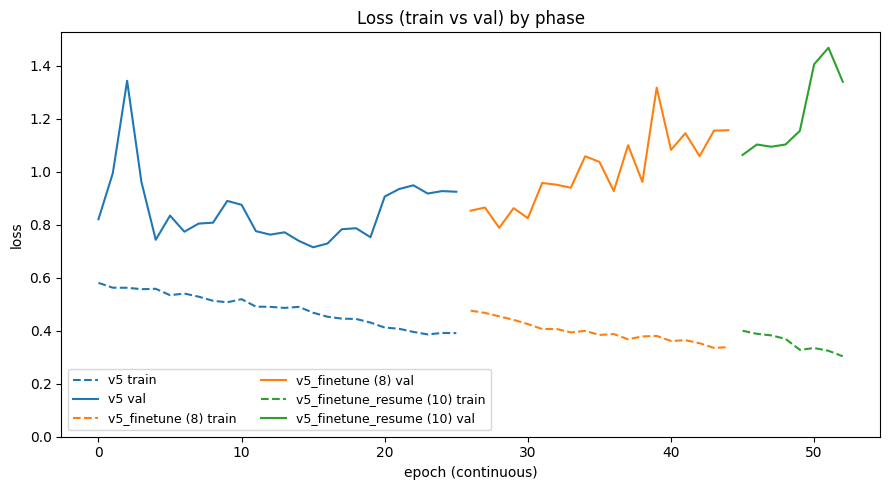

Saved -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/plots/loss_train_vs_val_by_phase_v5.png


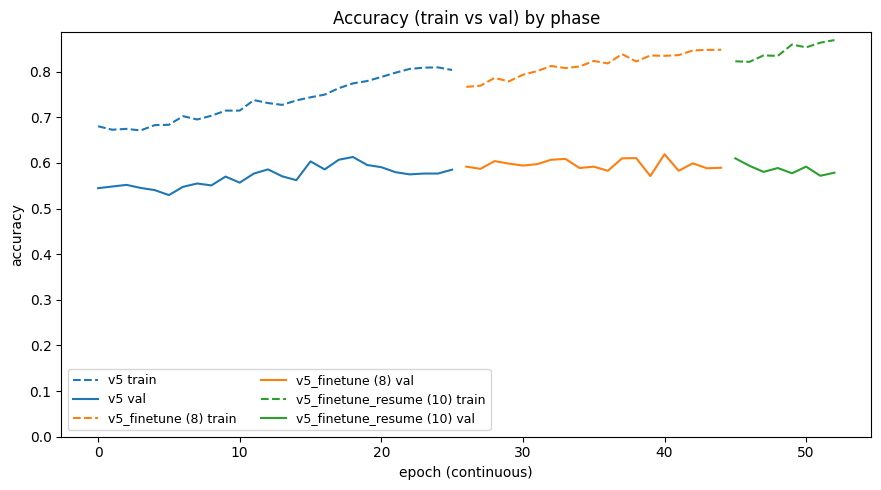

Saved -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/plots/acc_train_vs_val_by_phase_v5.png


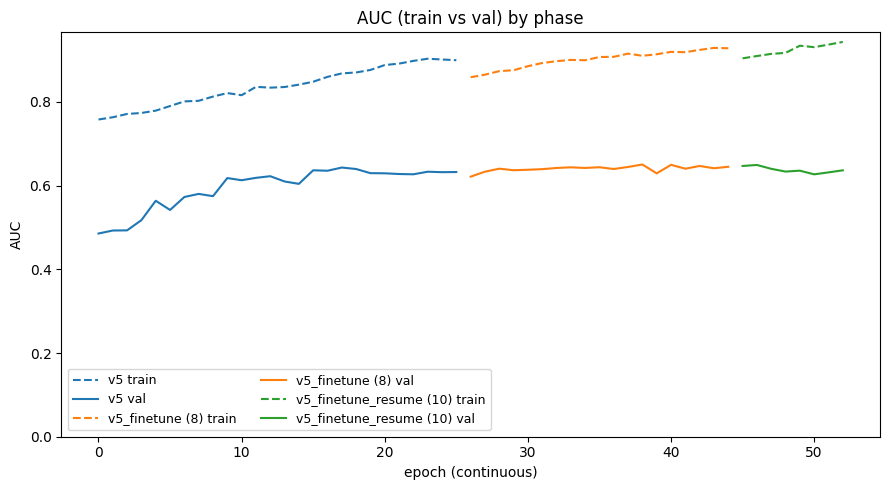

Saved -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/plots/auc_train_vs_val_by_phase_v5.png
207/207 [==============================] - 125s 599ms/step


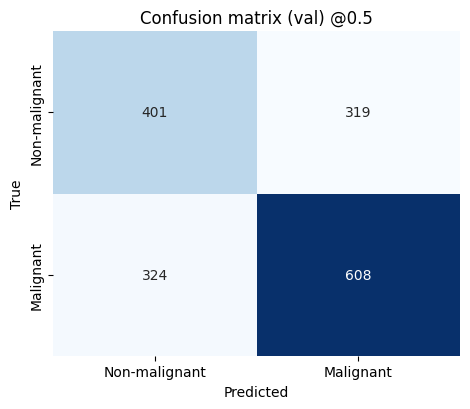

Saved -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/plots/confusion_matrix_val_v5.png


In [ ]:
# Cell 15 — merge logs (continuous epochs), summary, train vs val plots, + CM

files = [
    ("full",            "v5",                       METRICS_DIR/"train_full_log_v5.csv"),
    ("finetune",        "v5_finetune (8)",          METRICS_DIR/"train_full_log_v5_finetune.csv"),
    ("finetune_resume", "v5_finetune_resume (10)",  METRICS_DIR/"train_full_log_v5_finetune_resume.csv"),
]

dfs, offset = [], 0
for key, label, fp in files:
    if not fp.exists(): continue
    d = pd.read_csv(fp).copy()
    if "epoch" not in d: d["epoch"] = np.arange(len(d))
    d["phase_key"] = key; d["phase"] = label
    d["epoch_in_phase"] = d["epoch"]
    d["epoch_cum"] = d["epoch"] + offset
    offset += len(d)
    dfs.append(d)

if not dfs: raise SystemExit("No training logs found.")
logs = pd.concat(dfs, ignore_index=True)
logs.to_csv(METRICS_DIR/"train_logs_merged_v5.csv", index=False)

# summary (best by val_auc)
rows = []
for lbl, g in logs.groupby("phase", sort=False):
    b = g.loc[g["val_auc"].idxmax()]
    rows.append({
        "phase": lbl,
        "epochs_run": len(g),
        "best_epoch_in_phase": int(b["epoch_in_phase"]),
        "best_epoch_cum": int(b["epoch_cum"]),
        "best_val_auc": float(b["val_auc"]),
        "best_val_accuracy": float(b["val_accuracy"]),
        "best_val_loss": float(b["val_loss"]),
    })
summary = pd.DataFrame(rows)
summary.to_csv(METRICS_DIR/"phase_summary_v5.csv", index=False)
print(summary)

# plots: train vs val 
PLOTS_DIR.mkdir(parents=True, exist_ok=True)
colors = {"full":"tab:blue","finetune":"tab:orange","finetune_resume":"tab:green"}

def plot_pair(tr_col, val_col, title, ylabel, fname):
    plt.figure(figsize=(9,5))
    for key, label, _ in files:
        g = logs[logs["phase_key"]==key]
        if g.empty: continue
        plt.plot(g["epoch_cum"], g[tr_col],  "--", color=colors[key], label=f"{label} train")
        plt.plot(g["epoch_cum"], g[val_col], "-",  color=colors[key], label=f"{label} val")
    plt.xlabel("epoch (continuous)"); plt.ylabel(ylabel); plt.title(title)
    plt.legend(ncol=2, fontsize=9); plt.tight_layout()
    plt.ylim(bottom=0.0)
    out = PLOTS_DIR/fname; plt.savefig(out, dpi=160); plt.show(); print("Saved ->", out)

plot_pair("loss",     "val_loss",     "Loss (train vs val) by phase",     "loss",     "loss_train_vs_val_by_phase_v5.png")
plot_pair("accuracy", "val_accuracy", "Accuracy (train vs val) by phase", "accuracy", "acc_train_vs_val_by_phase_v5.png")
plot_pair("auc",      "val_auc",      "AUC (train vs val) by phase",      "AUC",      "auc_train_vs_val_by_phase_v5.png")

# confusion matrix
model = tf.keras.models.load_model(MODELS_DIR/"best_model_full_v5_finetune.keras", compile=False)

y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0).ravel().astype(int)
y_prob = model.predict(val_ds, verbose=1).ravel()
y_pred = (y_prob >= 0.5).astype(int)
pd.DataFrame({"true":y_true, "prob":y_prob, "pred@0.5":y_pred}).to_csv(METRICS_DIR/"val_predictions_v5.csv", index=False)

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
plt.figure(figsize=(4.8,4.2))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Non-malignant","Malignant"],
            yticklabels=["Non-malignant","Malignant"])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion matrix (val) @0.5")
plt.tight_layout()
out = PLOTS_DIR/"confusion_matrix_val_v5.png"
plt.savefig(out, dpi=160); plt.show(); print("Saved ->", out)

## 16: Grad-CAM

Grad-CAM saved: 12 pairs -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/visual_qc/gradcam_v5
Grad-CAM layer: block5_conv3


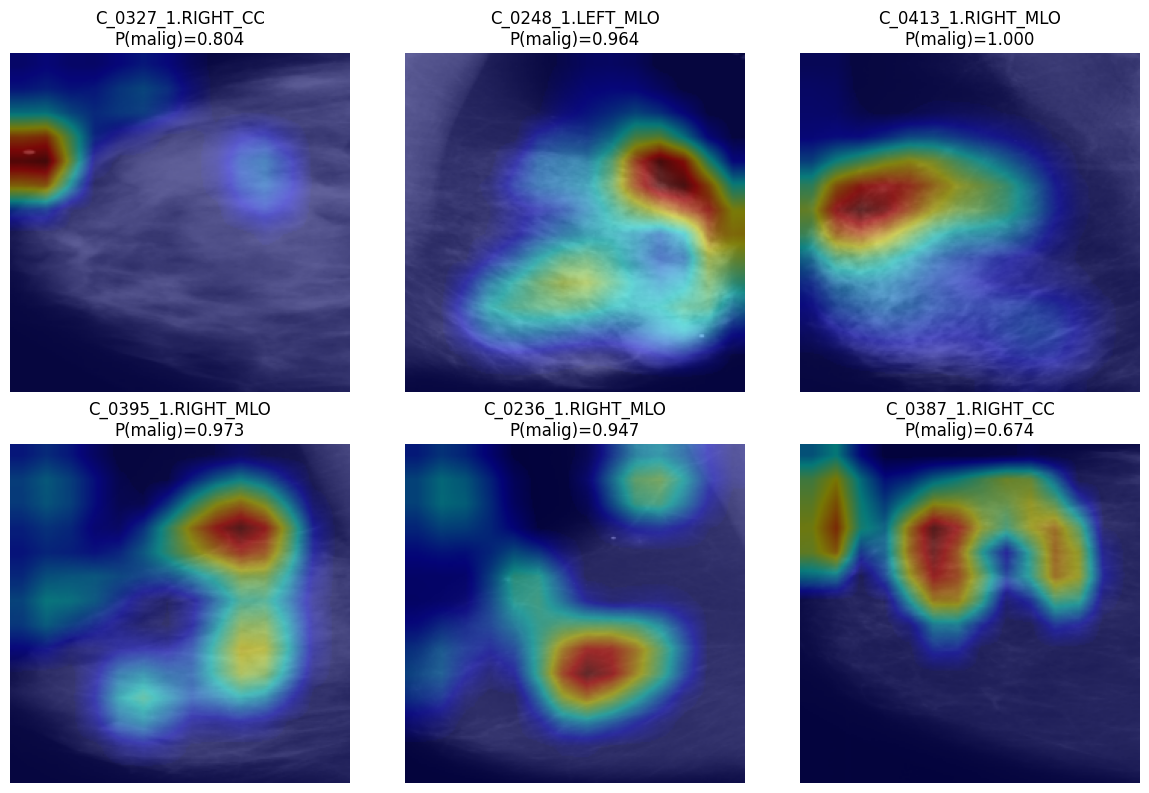

In [ ]:
# Cell 16 — Grad-CAM v5

out_dir = VQC_DIR / "gradcam_v5"
out_dir.mkdir(parents=True, exist_ok=True)

# load model
model = tf.keras.models.load_model(MODELS_DIR / "best_model_full_v5_finetune.keras", compile=False)
LAST_CONV = ("block5_conv3" if any(l.name == "block5_conv3" for l in model.layers)
             else next((l.name for l in reversed(model.layers) if isinstance(l, Conv2D)), None))
if LAST_CONV is None: raise RuntimeError("No Conv2D layers -> Grad-CAM not possible.")
grad_model = tf.keras.Model(model.inputs, [model.get_layer(LAST_CONV).output, model.output])

val_paths = (
    pd.read_csv(METRICS_DIR / "mask_qc_v5.csv")
      .query("split == 'val'")["image_path"].dropna()
)
val_paths = val_paths.sample(n=min(12, len(val_paths)), random_state=SEED).tolist()

def gradcam(path_str):
    g = cv2.imread(str(path_str), cv2.IMREAD_GRAYSCALE)
    if g is None: return None, None, None
    g = trim_borders(g)
    g = cv2.resize(g, IMG_SIZE, interpolation=cv2.INTER_AREA)
    g01  = g.astype("float32") / 255.0
    disp = cv2.cvtColor((g01 * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

    x3 = np.stack([g01, g01, g01], axis=-1)
    m, s = x3.mean(), x3.std() + 1e-7
    xb = ((x3 - m) / s)[None, ...].astype("float32")

    with tf.GradientTape() as tape:
        conv, pred = grad_model(xb, training=False)
        loss = pred[:, 0]
    grads = tape.gradient(loss, conv)
    w     = tf.reduce_mean(grads, axis=(1, 2))[0]
    cam   = tf.reduce_sum(conv[0] * w[None, None, :], axis=-1).numpy()
    cam   = np.maximum(cam, 0)
    cam   = cv2.resize(cam, (disp.shape[1], disp.shape[0]), interpolation=cv2.INTER_LINEAR)
    cam   = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    cam[cam < 0.02] = 0.0

    heat    = cv2.applyColorMap((cam * 255).astype(np.uint8), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(heat, 0.45, disp, 0.55, 0)
    return disp, overlay, float(pred.numpy().ravel()[0])

saved, previews = 0, []
for ip in val_paths:
    disp, ov, p = gradcam(ip)
    if disp is None: continue
    stem = Path(ip).stem
    cv2.imwrite(str(out_dir / f"{stem}_disp_v5.png"),    disp)
    cv2.imwrite(str(out_dir / f"{stem}_gradcam_v5.png"), ov)
    if len(previews) < 6:
        previews.append((ov, stem, p))
    saved += 1

print(f"Grad-CAM saved: {saved} pairs -> {out_dir}")
print("Grad-CAM layer:", LAST_CONV)

# Preview
import math, matplotlib.pyplot as plt
n, cols = len(previews), 3
rows = max(1, math.ceil(n / cols))
plt.figure(figsize=(4*cols, 4*rows))
for i, (img_bgr, stem, prob) in enumerate(previews, 1):
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    ax = plt.subplot(rows, cols, i)
    ax.imshow(img_rgb); ax.axis("off")
    ax.set_title(f"{stem}\nP(malig)={prob:.3f}")
plt.tight_layout(); plt.show()

Saved 10 panels -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/outputs/visual_qc/mask_vs_gradcam_v5


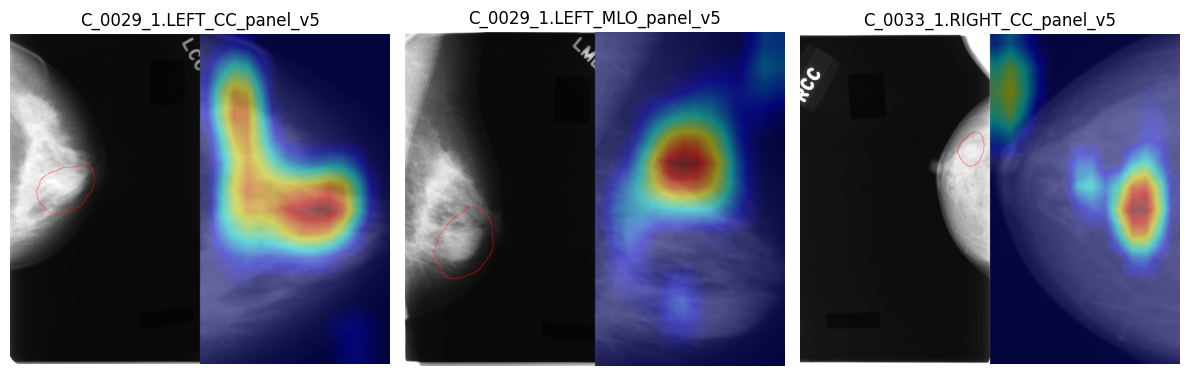

In [ ]:
# Cell 16b — Panels (Mask overlay | Grad-CAM)

PANEL_DIR = VQC_DIR / "mask_vs_gradcam_v5"; PANEL_DIR.mkdir(parents=True, exist_ok=True)
mdir, gdir = VQC_DIR / "mask_overlays_v5", VQC_DIR / "gradcam_v5"
mf = pd.read_csv(METRICS_DIR / "mask_qc_v5.csv")
stem2ip = {Path(p).stem: p for p in mf["image_path"].dropna()}

cand = [p.stem.replace("_overlay_v5","") for p in sorted(mdir.glob("*_overlay_v5.png"))][:10]
saved = 0
for k in cand:
    gpath = gdir / f"{k}_gradcam_v5.png"
    if not gpath.exists() and k in stem2ip:
        _, gc, _ = gradcam(stem2ip[k])
        if gc is not None: cv2.imwrite(str(gpath), gc)
    a = cv2.imread(str(mdir / f"{k}_overlay_v5.png")); b = cv2.imread(str(gpath))
    if a is None or b is None: continue
    if a.shape[:2] != b.shape[:2]: b = cv2.resize(b, (a.shape[1], a.shape[0]))
    cv2.imwrite(str(PANEL_DIR / f"{k}_panel_v5.png"), np.concatenate([a, b], axis=1)); saved += 1
print(f"Saved {saved} panels -> {PANEL_DIR}")

# Preview
files = sorted(PANEL_DIR.glob("*_panel_v5.png"))[:3]
if files:
    plt.figure(figsize=(12, 5))
    for i, fp in enumerate(files, 1):
        img = cv2.cvtColor(cv2.imread(str(fp)), cv2.COLOR_BGR2RGB)
        ax = plt.subplot(1, len(files), i)
        ax.imshow(img); ax.axis("off"); ax.set_title(fp.stem)
    plt.tight_layout(); plt.show()
else:
    print("No panels found to preview in:", PANEL_DIR)

## 17: Export artifacts for UI

In [ ]:
# Cell 17 — Export artifacts for the UI (v5)

import json, shutil, tensorflow as tf

APP_DIR = ROOT / "streamlit_app" / "app_bundle_v5"
APP_DIR.mkdir(parents=True, exist_ok=True)

model_src = MODELS_DIR / "best_model_full_v5_finetune.keras"
if not model_src.exists():
    raise FileNotFoundError(f"Model not found: {model_src}")
shutil.copy2(model_src, APP_DIR / "model.keras")

m = tf.keras.models.load_model(model_src, compile=False)
try:
    last_conv = next(l.name for l in reversed(m.layers) if isinstance(l, tf.keras.layers.Conv2D))
except StopIteration:
    last_conv = "block5_conv3"

config = {
    "img_size": [int(IMG_SIZE[0]), int(IMG_SIZE[1])],
    "last_conv": last_conv,
    "class_names": ["Non-malignant", "Malignant"],
    "threshold": 0.5,
    "preprocess": "zscore",
    "letterbox": False
}
(APP_DIR / "config.json").write_text(json.dumps(config, indent=2))
print("App bundle created ->", APP_DIR)
print(" - model.keras")
print(" - config.json")

dst = APP_DIR / "model_saved"
if dst.exists(): shutil.rmtree(dst)
tf.saved_model.save(m, str(dst))
print("SavedModel exported to:", dst)

App bundle created -> /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/streamlit_app/app_bundle_v5
 - model.keras
 - config.json
SavedModel exported to: /Users/dash/Desktop/SIMNotes/Y3S2/CM3070_FP/Breast_Cancer_Project/streamlit_app/app_bundle_v5/model_saved
